**Preprocessing + EDA + Inferential Statistics**

**Content**

1. Preprocessing Functions  

2. EDA Functions – Run Preprocessing, EDA, and OLS on all subreddits  
&nbsp;&nbsp;&nbsp;2.1 r/liberal  
&nbsp;&nbsp;&nbsp;2.2 r/conservative  
&nbsp;&nbsp;&nbsp;2.3 r/funny  
&nbsp;&nbsp;&nbsp;2.4 r/politics  
&nbsp;&nbsp;&nbsp;2.5 All 4 subreddits combined

3. OLS controlling model for up-/downvotes, mentioning trump, moral outrage and sentiment score on r/politics

4. Additional Plots


Files needed: {Subreddit}_with_scores.csv for each Subreddit and "moral_outrage_words.txt" for counting moral outrage words



In [24]:
# importing relevant libraries
import zstandard
import os
import json
import sys
import csv
from datetime import datetime
import logging.handlers
import pandas as pd
from googleapiclient import discovery # need to pip install too
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, pearsonr, spearmanr
from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm



1. Preprocessing


In [3]:
# preprocessing: 


def mentions_trump(data):
    data["mentions_trump"] = 0

    for row in data.itertuples(index=True):
        if "trump" in row.body.lower(): 
            data.at[row.Index, "mentions_trump"] = 1
    
    # Standardize sentiment
    scaler = StandardScaler()
    data['mentions_trump_z'] = scaler.fit_transform(data[['mentions_trump']])
    print("Mentioning Trump Computation done")
    return data


def compute_sentiment_scores(data):
    sid_obj = SentimentIntensityAnalyzer()
    data['sentiment_score'] = 10000 # set high, so we can easily spot if it didnt label correctly
    for index, row in data.iterrows():
        text = row['body']
        sentiment_dict = sid_obj.polarity_scores(text)
        data.at[index, 'sentiment_score'] = sentiment_dict['compound']

        # Standardize sentiment
        scaler = StandardScaler()
        data['sentiment_score_z'] = scaler.fit_transform(data[['sentiment_score']])
       

    print("Sentiment Score Computation done")
    return data

def compute_moral_outrage_column(data):
    with open("moral_outrage_words.txt", "r") as f:
        outrage_words = [line.strip() for line in f if line.strip()]
    pattern = '|'.join([w.replace('*', r'\w*') for w in outrage_words])
    
    data['moral_outrage'] = data['body'].str.lower().str.count(pattern)
    
    # Standardize
    scaler = StandardScaler()
    data['moral_outrage_z'] = scaler.fit_transform(data[['moral_outrage']])
    print("Moral Outrage Computation done")
    return data

def standardize_incivility_scores(data):
    scaler = StandardScaler()
    data['incivility_score_z'] = scaler.fit_transform(data[['incivility_score']])
    print("Incivility Standardisation done")
    return data

def preprocess(data):
    data["month"] = pd.to_datetime(data["created_utc"], unit="s").dt.to_period("M")
    data["year"] = pd.to_datetime(data["created_utc"], unit="s").dt.to_period("Y")
    data = data [~data['body'].isin(['[deleted]', '[removed]'])]
    data = mentions_trump(data)
    data = compute_sentiment_scores(data)
    data =  compute_moral_outrage_column(data)
    data = standardize_incivility_scores(data)

    return data


In [4]:
# EDA Functions

def monthly_distribution(data, Subreddit):
    month_counts = data["month"].value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=month_counts.index, y=month_counts.values)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Month', fontweight="semibold")
    plt.ylabel('Number of Observations',fontweight="semibold")
    plt.title('Number of Observations per month', fontweight="bold")

    ticks_to_show = range(0, len(month_counts), 12)
    plt.xticks(ticks=ticks_to_show, labels=month_counts.index.astype(str)[::12], rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"Monthly_Distribution_{Subreddit}.png", bbox_inches="tight")
    plt.show()

def yearly_distribution(data, Subreddit):
    year_counts = data["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=year_counts.index, y=year_counts.values)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('year', fontweight="semibold")
    plt.ylabel('Number of Observations',fontweight="semibold")
    plt.title('Number of Observations per year', fontweight="bold")

    plt.tight_layout()
    plt.savefig(f"Yearly_Distribution_{Subreddit}.png", bbox_inches="tight")
    plt.show()


def yearly_incivility_score(data, Subreddit):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data, x="year", y="incivility_score", showfliers=True)
    plt.xlabel("Year")
    plt.ylabel("Incivility Score")
    plt.xticks(rotation=60)
    plt.title(f"Yearly distribution of Incivility Score in r/{Subreddit}")
    plt.show()

    # calculate increase from 2012 to 2024
    data["year_int"] = data["year"].dt.year
    m2024 = data.loc[data["year_int"] == 2024, "incivility_score"].mean()
    m2012 = data.loc[data["year_int"] == 2012, "incivility_score"].mean()
    increase = m2024/m2012
    print(f'Mean 2012: {m2012}. Mean 2024: {m2024}. Relative Increase: {increase}')

def histogram_incivility_score(data, Subreddit):
    plt.figure(figsize=(8, 5))
    sns.histplot(data= data, x = "incivility_score")
    plt.xlabel('Incivility score', fontweight="semibold")
    plt.ylabel('Count',fontweight="semibold")
    plt.title('Histogram of incivility Scores', fontweight="bold")
    plt.tight_layout()
    plt.savefig(f"Histogram_Incivility_{Subreddit}.png", bbox_inches="tight")
    plt.show()
    scores = data["incivility_score"].dropna()

    W, p = shapiro(scores)   # W = statistic, p = p-value
    print(f"W = {W:.3f}, p = {p:.3g}")


def yearly_sentiment_score(data, Subreddit):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data, x="year", y="sentiment_score", showfliers=True)
    plt.xlabel("Year")
    plt.ylabel("Sentiment Score")
    plt.xticks(rotation=60)
    plt.title(f"Yearly distribution of Sentiment Score in r/{Subreddit}")
    plt.show()

def yearly_moral_outrage_score(data, Subreddit):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data, x="year", y="moral_outrage", showfliers=True)
    plt.xlabel("Year")
    plt.ylabel("Moral Outrage Score")
    plt.xticks(rotation=60)
    plt.title(f"Yearly distribution of Moral Score in r/{Subreddit}")
    plt.show()

def yearly_mentions_trump_score(data, Subreddit):
    plt.figure(figsize=(10,6))
    yearly = data.groupby("year")["mentions_trump"].mean().reset_index()
    sns.barplot(data=yearly, x="year", y="mentions_trump")
    plt.xlabel("Year")
    plt.ylabel("Percentage of posts mentioning Trump")
    plt.xticks(rotation=60)
    plt.title(f"Yearly Percentage of Posts Mentioning Trump in r/{Subreddit}")
    plt.show()

def examples_invcivility_score(data):
    top2 = data.nlargest(2, 'incivility_score')[['body', 'incivility_score']]
    print("Top 2 Incivility Tweets:\n")
    for i, row in top2.iterrows():
        print(f"Score: {row['incivility_score']}\nTweet: {row['body']}\n")

    # 2 niedrigste incivility_score
    bottom2 = data.nsmallest(2, 'incivility_score')[['body', 'incivility_score']]
    print("Bottom 2 Incivility Tweets:\n")
    for i, row in bottom2.iterrows():
        print(f"Score: {row['incivility_score']}\nTweet: {row['body']}\n")

def run_all_descriptives(data, Subreddit):
    print(data.describe())
    monthly_distribution(data, Subreddit)
    yearly_distribution(data, Subreddit)
    histogram_incivility_score(data, Subreddit)
    yearly_incivility_score(data, Subreddit)
    yearly_mentions_trump_score(data, Subreddit)
    yearly_sentiment_score(data, Subreddit)
    yearly_moral_outrage_score(data, Subreddit)
    examples_invcivility_score(data)



2.1 Run descriptives and inferential statistics on r/liberal

In [5]:
Liberal_with_scores = pd.read_csv("Liberal_with_scores.csv")
Liberal_with_scores = preprocess(Liberal_with_scores)



Mentioning Trump Computation done


C:\Users\TG2023\AppData\Local\Temp\ipykernel_22320\390790507.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, 'sentiment_score'] = sentiment_dict['compound']


Sentiment Score Computation done
Moral Outrage Computation done
Incivility Standardisation done


        created_utc        score  controversiality  gilded  incivility_score  \
count  2.964000e+03  2964.000000       2964.000000  2964.0       2964.000000   
mean   1.530446e+09     4.508097          0.031714     0.0          0.204070   
std    1.184482e+08    11.550427          0.175267     0.0          0.224336   
min    1.325600e+09   -51.000000          0.000000     0.0          0.000481   
25%    1.427976e+09     1.000000          0.000000     0.0          0.030153   
50%    1.530348e+09     2.000000          0.000000     0.0          0.107399   
75%    1.632926e+09     4.000000          0.000000     0.0          0.322899   
max    1.735490e+09   188.000000          1.000000     0.0          0.974994   

       mentions_trump  mentions_trump_z  sentiment_score  sentiment_score_z  \
count     2964.000000      2.964000e+03      2964.000000       2.964000e+03   
mean         0.096829      3.835588e-17        -0.008911       4.794485e-18   
std          0.295774      1.000169e+00   

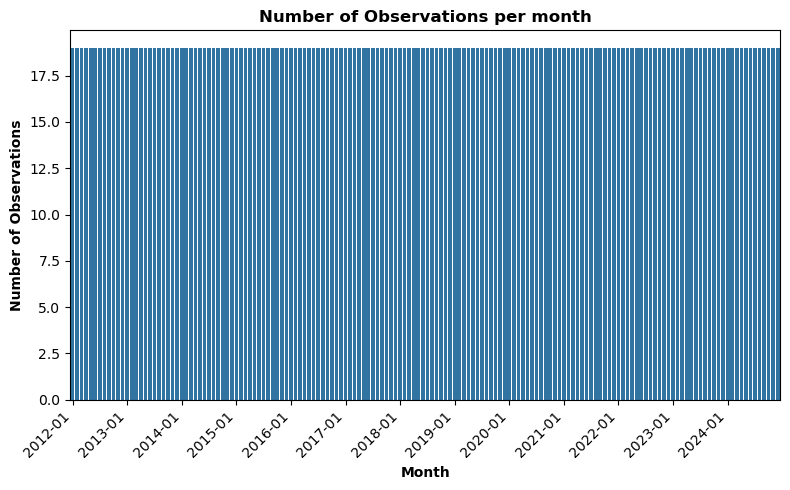

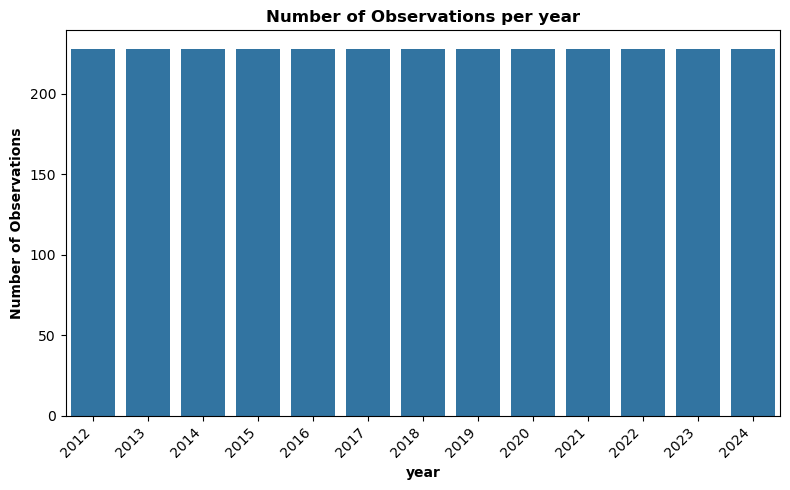

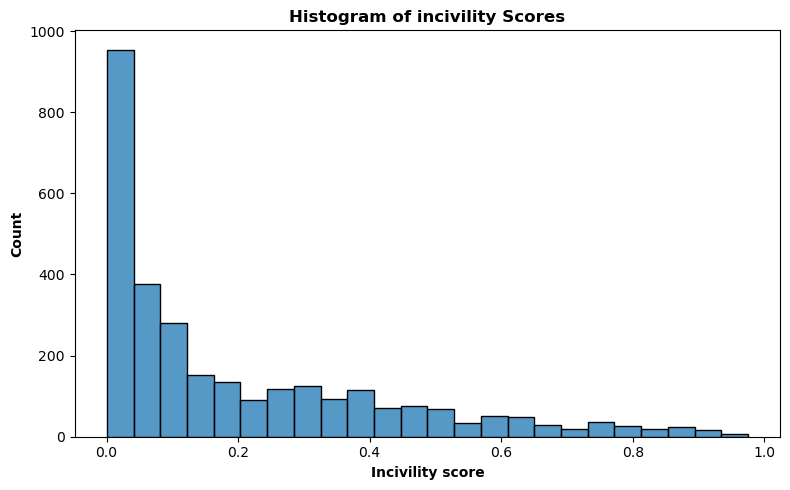

W = 0.814, p = 3.83e-50


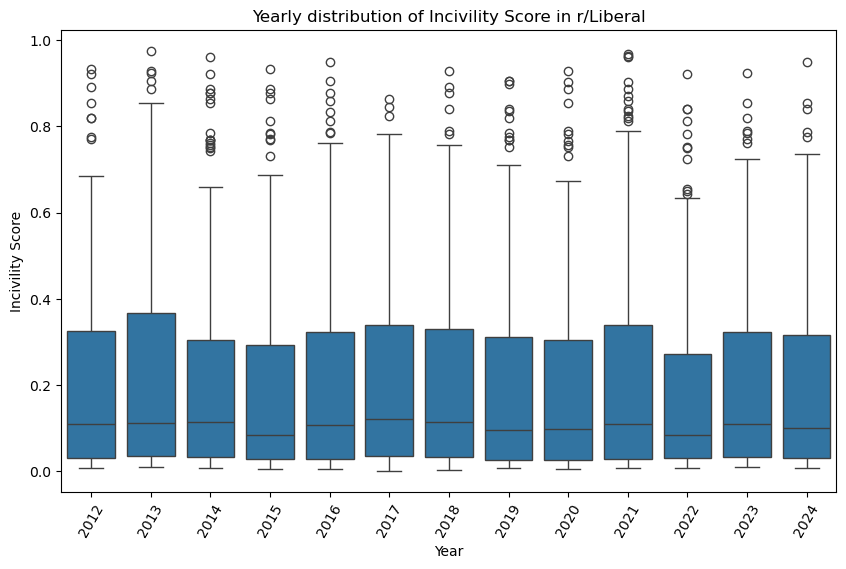

Mean 2012: 0.19720546795701754. Mean 2024: 0.1880938033833333. Relative Increase: 0.9537960855341486


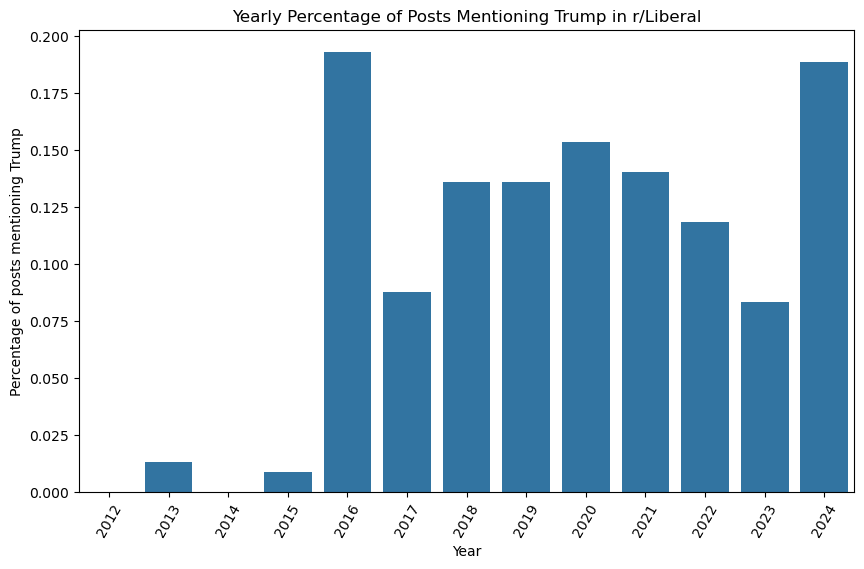

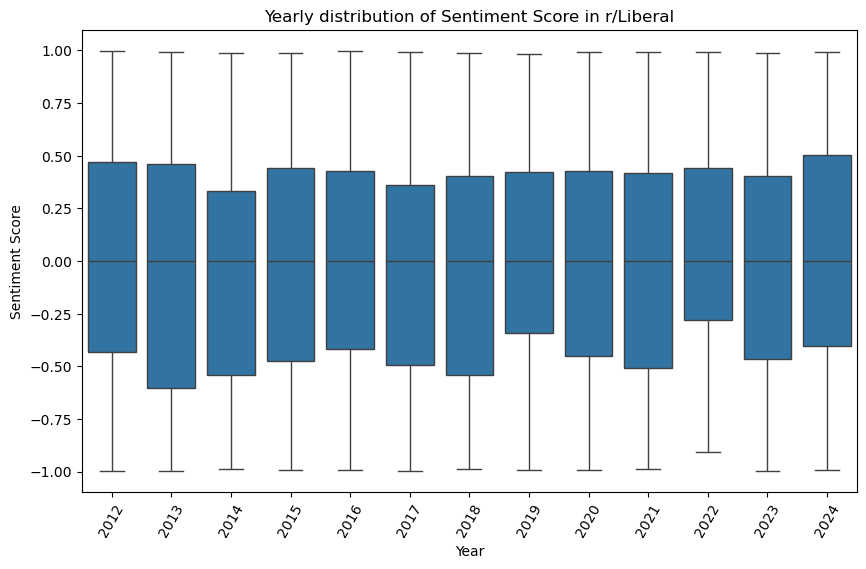

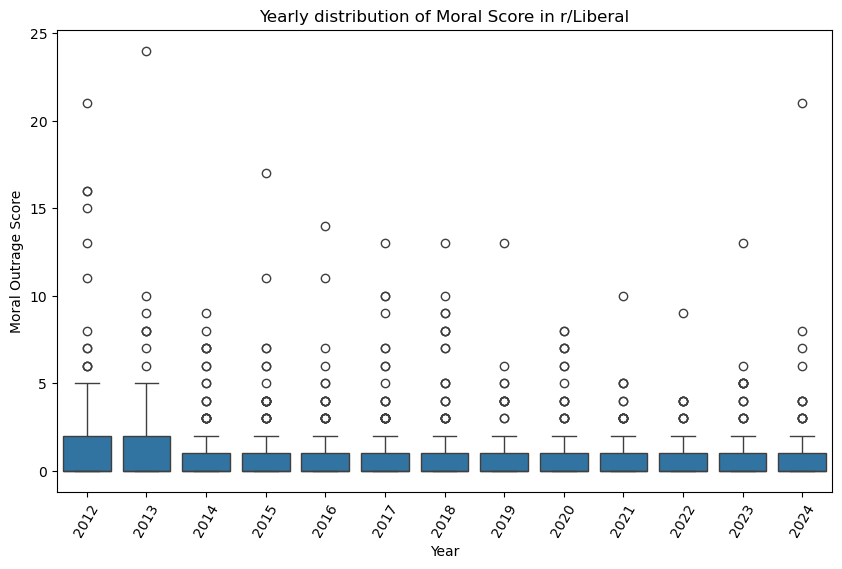

Top 2 Incivility Tweets:

Score: 0.9749944
Tweet: You're a fucking imbecile.

Score: 0.968226
Tweet: Fuck all Republicans.  Scum!!!

Bottom 2 Incivility Tweets:

Score: 0.00048104455
Tweet: Roe v Wade.

Score: 0.0035813276
Tweet: California 2018 Election 

[Primary Election Registration Deadline](http://registertovote.ca.gov/): May 16, 2018 

[Primary Election](http://www.sos.ca.gov/elections/voter-registration/vote-mail/#apply): June 5, 2018 

[General Election Registration Deadline](http://registertovote.ca.gov/): October 22, 2018 

[General Election](http://www.sos.ca.gov/elections/voter-registration/vote-mail/#apply): November 6, 2018 





In [6]:

run_all_descriptives(Liberal_with_scores, "Liberal")

In [ ]:

# defining OLS function to predict incivility scores over time 2012 -2024
def linreg_predicting_incivility(data):

    # Aggregate to monthly averages
    monthly = data.groupby('month')['incivility_score'].mean().reset_index()

    # Add numeric time predictor
    monthly = monthly[monthly['month'].dt.year >= 2012].reset_index(drop=True)
    monthly['month_'] = range(len(monthly))

    # Simple OLS regression
    X = sm.add_constant(monthly['month_'])  # use numeric month_
    y = monthly['incivility_score']
    model = sm.OLS(y, X).fit()
    print(model.summary())


    plt.figure(figsize=(12,6))
    plt.plot(monthly['month'].astype(str), monthly['incivility_score'], marker='o', label='Monthly avg')
    plt.plot(monthly['month'].astype(str), model.predict(sm.add_constant(monthly['month_'])), 
            color='red', label='OLS trend')
    xticks = [m for m in monthly['month'].astype(str) if m.endswith('01')]
    plt.xticks(xticks, rotation=60)
    plt.xlabel("Month")
    plt.ylabel("Average Incivility Score")
    plt.title("Monthly Incivility (2011–2024)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # print confidence intervals with 5 decimals
    ci = model.conf_int()  # default 95% CI
    ci = ci.round(5)       # round to 5 decimals
    print(ci)
    
    # check regression residuals to verify ols assumptions
    ols = model
    sm.graphics.plot_regress_exog(ols,"month_")
    sm.graphics.tsa.plot_acf(ols.resid)


    

def linreg_predicting_incivility_2012_to_2019(data):

    # Aggregate to monthly averages
    monthly = data.groupby('month')['incivility_score'].mean().reset_index()

    # Add numeric time predictor
    monthly = monthly[(monthly['month'].dt.year >= 2012) & (monthly['month'].dt.year <= 2019)].reset_index(drop=True)
    monthly['month_'] = range(len(monthly))

    # Simple OLS regression
    X = sm.add_constant(monthly['month_'])  # use numeric month_
    y = monthly['incivility_score']
    model = sm.OLS(y, X).fit()
    print(model.summary())


    plt.figure(figsize=(12,6))
    plt.plot(monthly['month'].astype(str), monthly['incivility_score'], marker='o', label='Monthly avg')
    plt.plot(monthly['month'].astype(str), model.predict(sm.add_constant(monthly['month_'])), 
            color='red', label='OLS trend')
    xticks = [m for m in monthly['month'].astype(str) if m.endswith('01')]
    plt.xticks(xticks, rotation=60)
    plt.xlabel("Month")
    plt.ylabel("Average Incivility Score")
    plt.title("Monthly Incivility (2011–2019)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    ols = model
    sm.graphics.plot_regress_exog(ols,"month_")
    sm.graphics.tsa.plot_acf(ols.resid)

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.434
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.121
Time:                        19:20:33   Log-Likelihood:                 242.26
No. Observations:                 156   AIC:                            -480.5
Df Residuals:                     154   BIC:                            -474.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2151      0.008     26.195      0.0

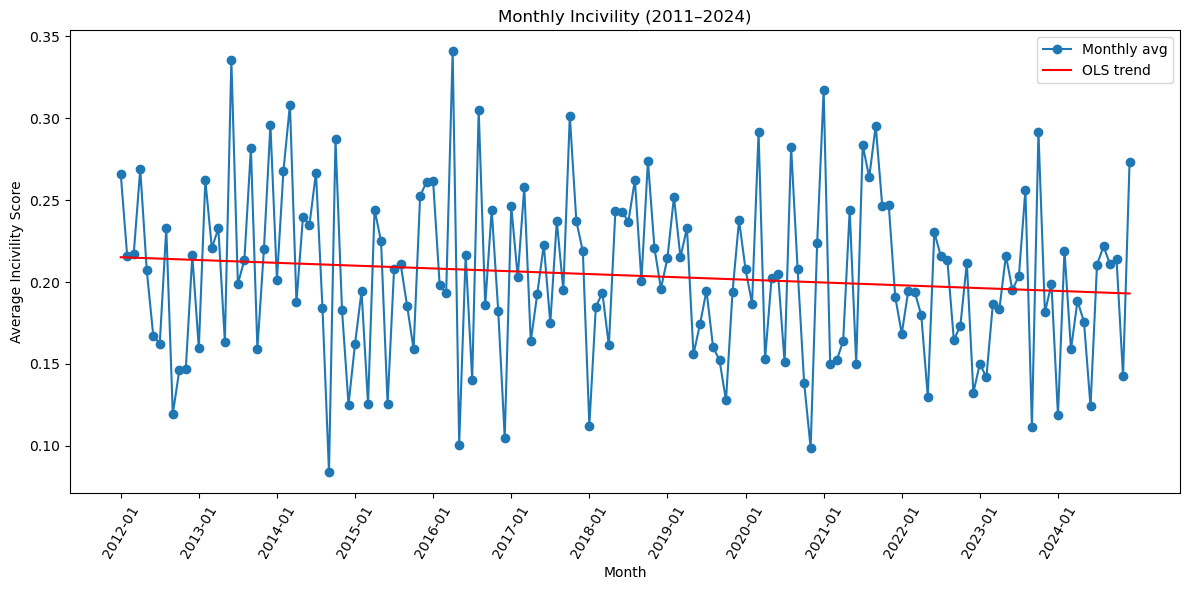

              0        1
const   0.19892  0.23137
month_ -0.00032  0.00004
                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3010
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.585
Time:                        19:20:33   Log-Likelihood:                 147.30
No. Observations:                  96   AIC:                            -290.6
Df Residuals:                      94   BIC:                            -285.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

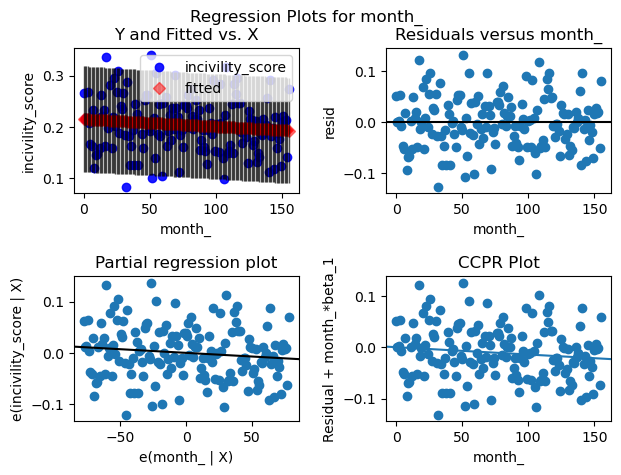

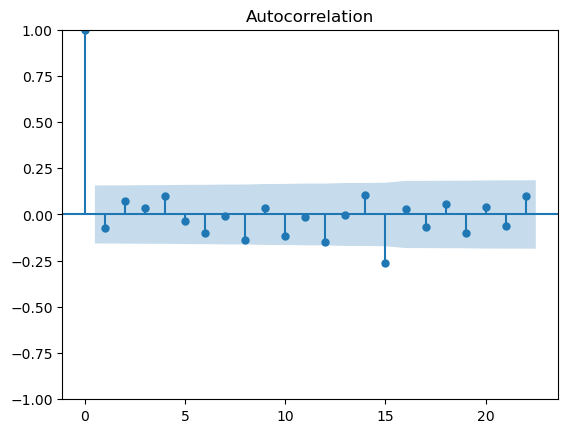

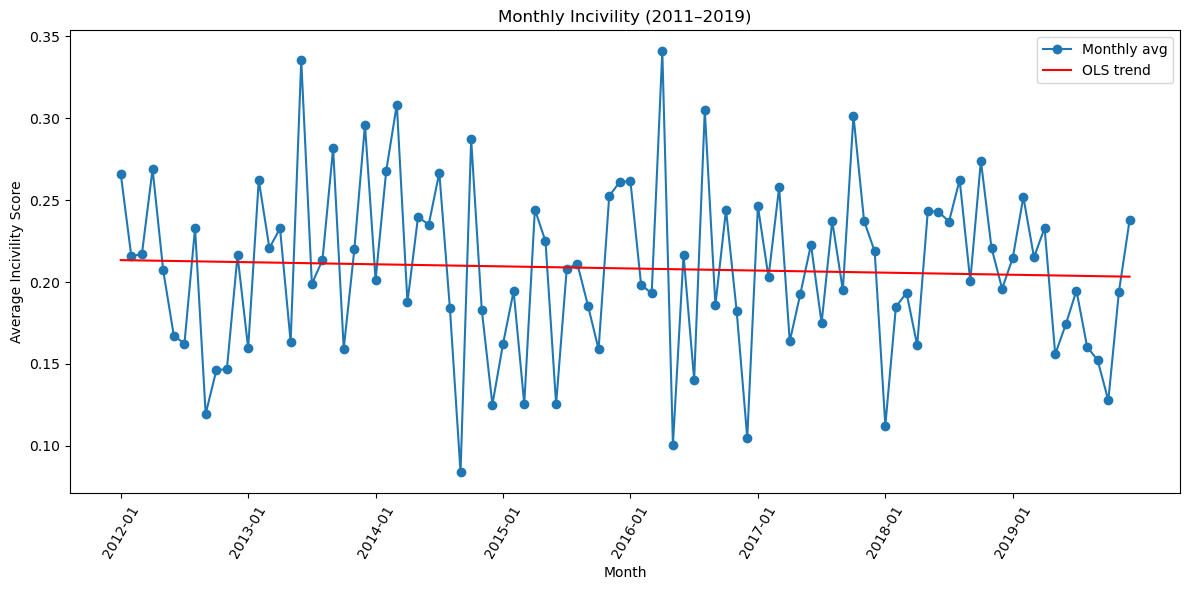

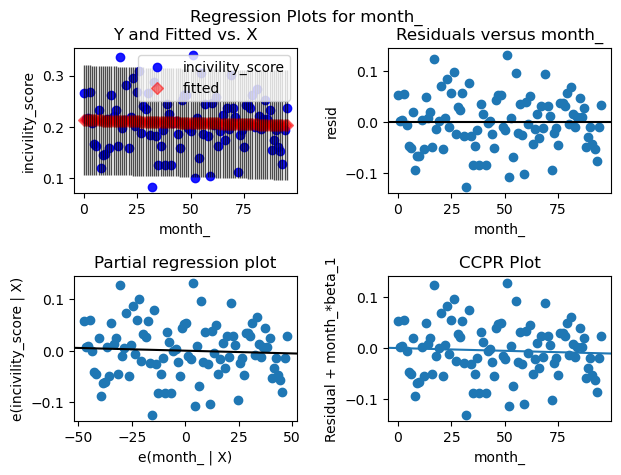

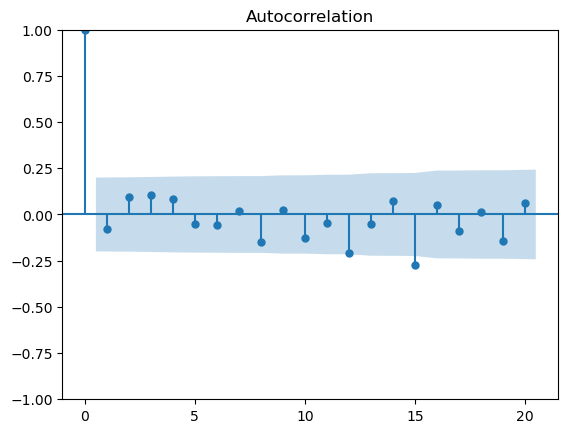

In [8]:
linreg_predicting_incivility(Liberal_with_scores)
linreg_predicting_incivility_2012_to_2019(Liberal_with_scores)

2.2 Run descriptives and inferential statistics on r/conservative

In [9]:
Conservative_with_scores = pd.read_csv("Conservative_with_scores.csv")
Conservative_with_scores = preprocess(Conservative_with_scores)



Mentioning Trump Computation done


C:\Users\TG2023\AppData\Local\Temp\ipykernel_22320\390790507.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.6581' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, 'sentiment_score'] = sentiment_dict['compound']


Sentiment Score Computation done
Moral Outrage Computation done
Incivility Standardisation done


        created_utc        score  controversiality  gilded  incivility_score  \
count  2.964000e+03  2964.000000       2964.000000  2964.0       2964.000000   
mean   1.530467e+09     7.592105          0.085695     0.0          0.183013   
std    1.184425e+08    28.867263          0.279960     0.0          0.212503   
min    1.325467e+09   -86.000000          0.000000     0.0          0.000000   
25%    1.427826e+09     1.000000          0.000000     0.0          0.028473   
50%    1.530306e+09     2.000000          0.000000     0.0          0.087165   
75%    1.632997e+09     6.000000          0.000000     0.0          0.280034   
max    1.735487e+09   853.000000          1.000000     0.0          0.960691   

       mentions_trump  mentions_trump_z  sentiment_score  sentiment_score_z  \
count     2964.000000      2.964000e+03      2964.000000       2.964000e+03   
mean         0.065789      1.917794e-17         0.001681       2.996553e-17   
std          0.247956      1.000169e+00   

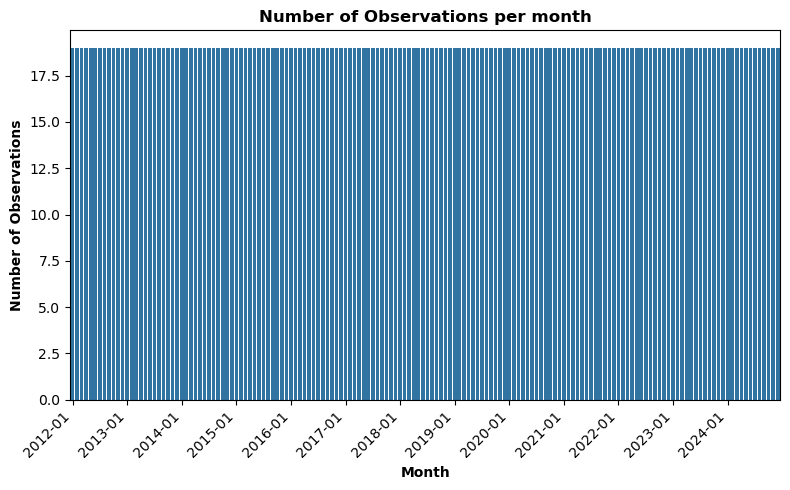

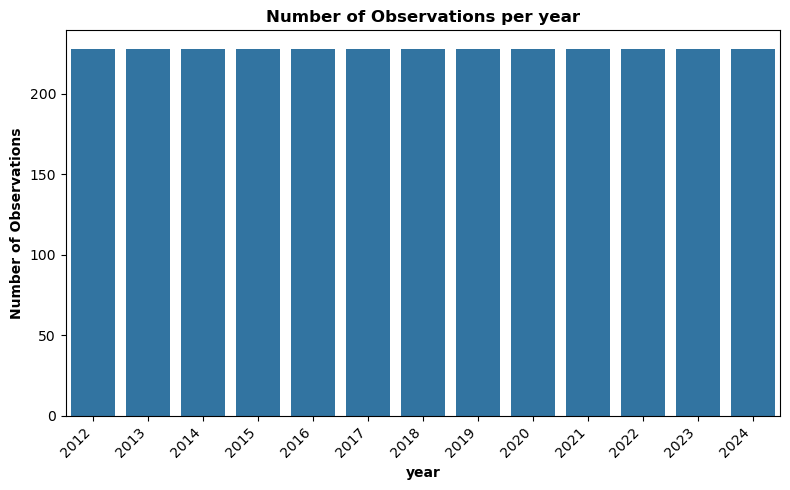

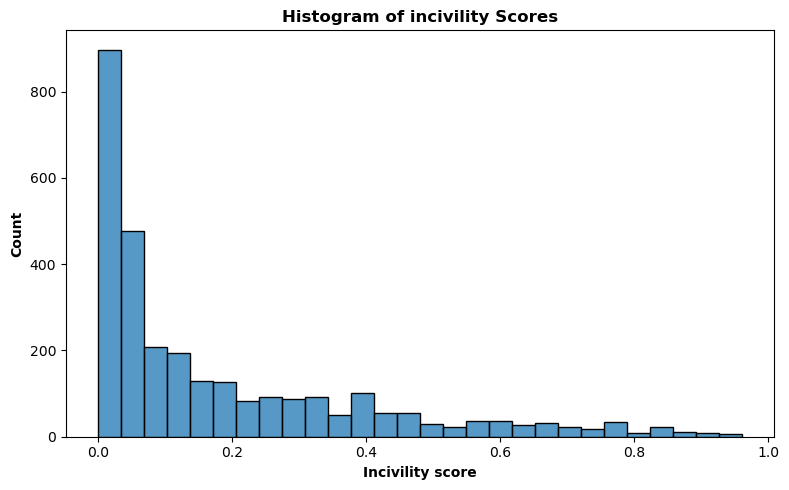

W = 0.785, p = 1.37e-52


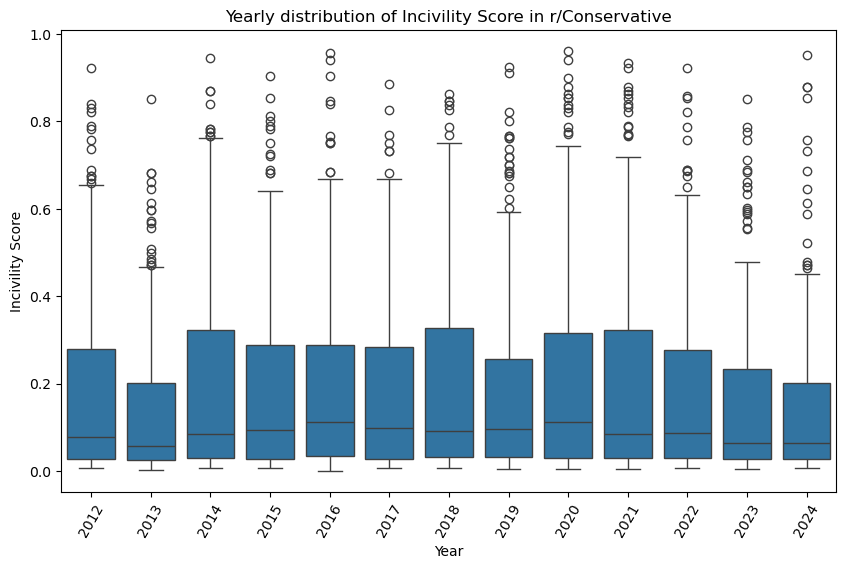

Mean 2012: 0.1828466950438597. Mean 2024: 0.14800638200701755. Relative Increase: 0.8094561510751673


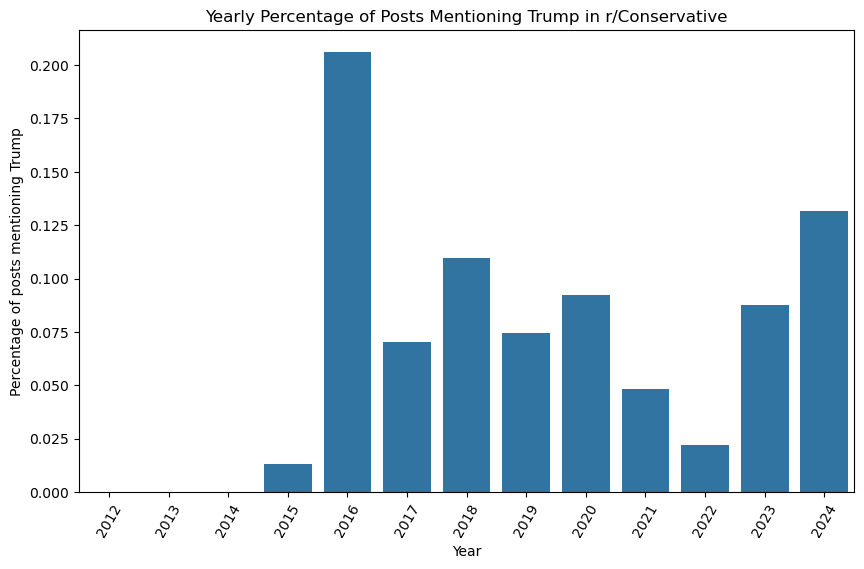

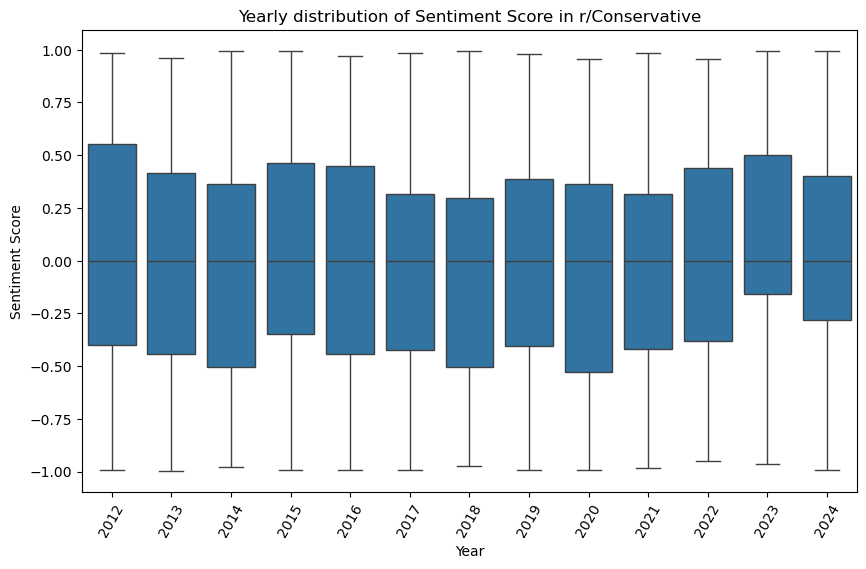

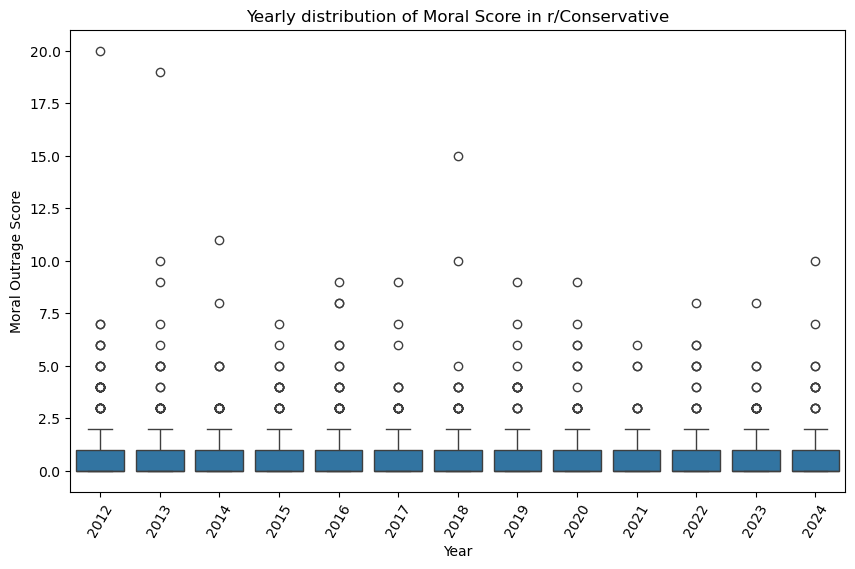

Top 2 Incivility Tweets:

Score: 0.96069145
Tweet: Spineless weak ass bitch

Score: 0.9563754
Tweet: What a piece of shit loser. 

Bottom 2 Incivility Tweets:

Score: 0.0
Tweet:  

Score: 0.0022933062
Tweet: Quoi?



In [10]:

run_all_descriptives(Conservative_with_scores, "Conservative")

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1050
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.746
Time:                        19:20:45   Log-Likelihood:                 230.48
No. Observations:                 156   AIC:                            -457.0
Df Residuals:                     154   BIC:                            -450.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1855      0.009     20.942      0.0

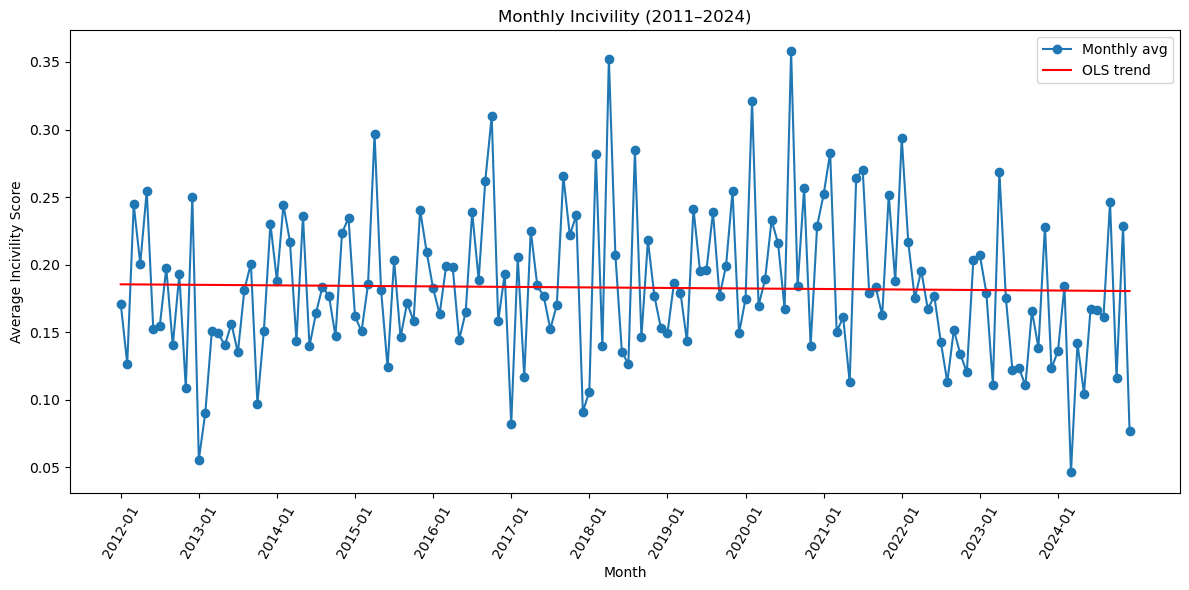

              0        1
const   0.16800  0.20299
month_ -0.00023  0.00016
                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.736
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.101
Time:                        19:20:46   Log-Likelihood:                 149.02
No. Observations:                  96   AIC:                            -294.0
Df Residuals:                      94   BIC:                            -288.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

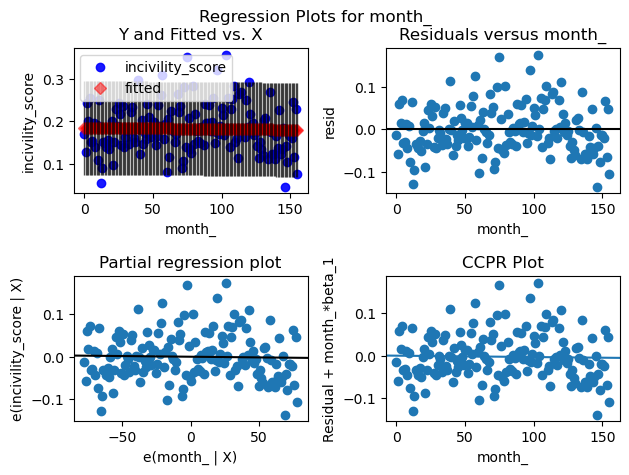

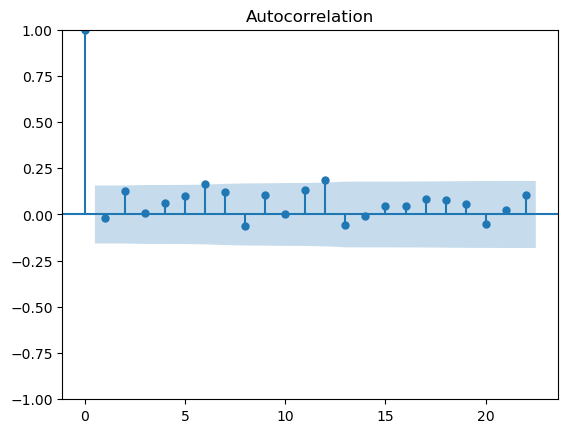

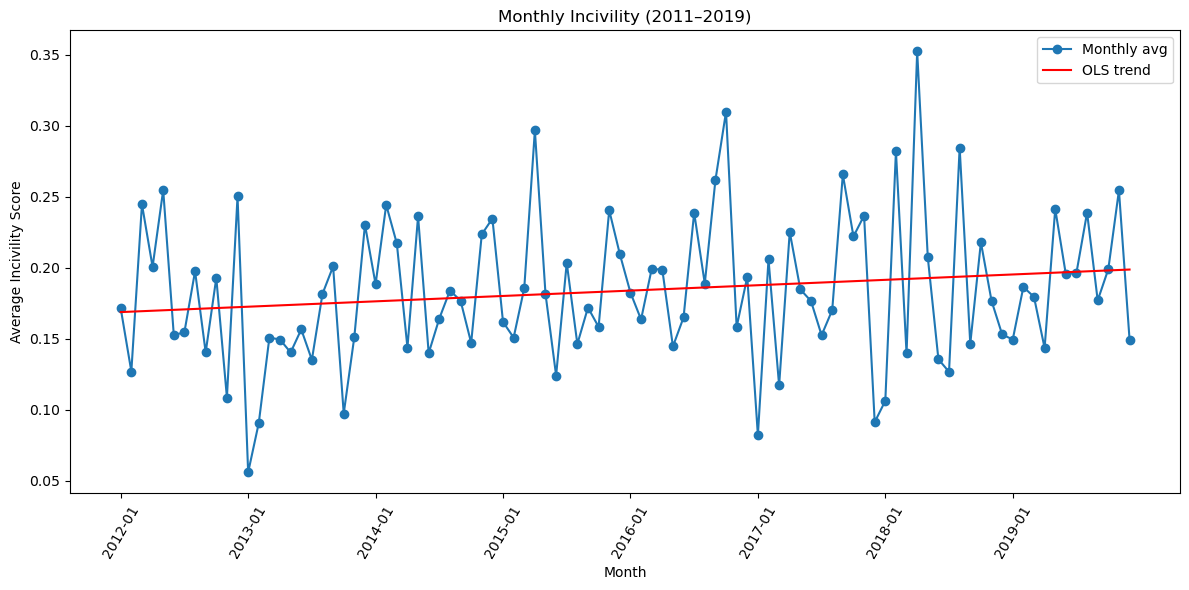

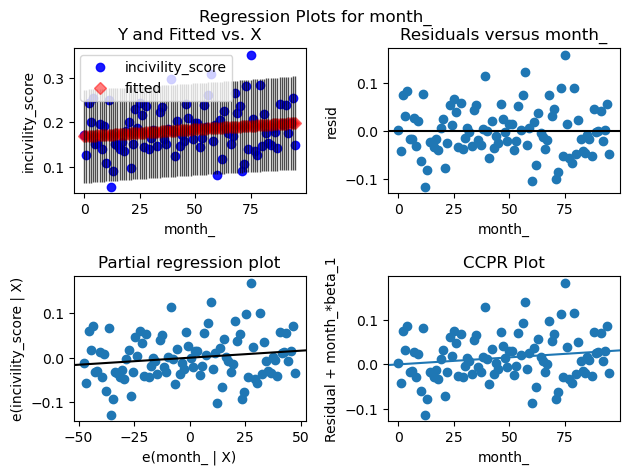

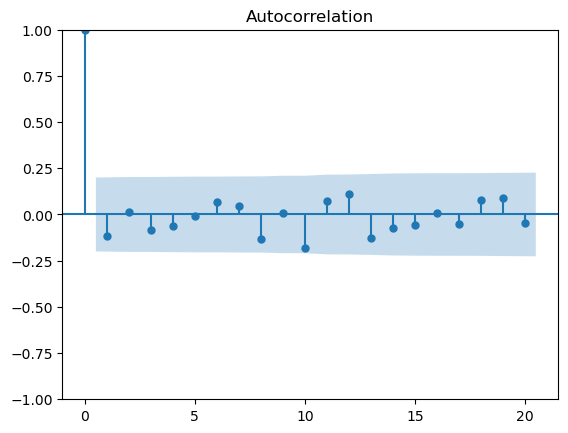

In [11]:
linreg_predicting_incivility(Conservative_with_scores)
linreg_predicting_incivility_2012_to_2019(Conservative_with_scores)

2.3 2.2 Run descriptives and inferential statistics on r/funny

In [12]:
funny_with_scores = pd.read_csv("funny_with_scores.csv")
funny_with_scores = preprocess(funny_with_scores)



Mentioning Trump Computation done


C:\Users\TG2023\AppData\Local\Temp\ipykernel_22320\390790507.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, 'sentiment_score'] = sentiment_dict['compound']


Sentiment Score Computation done
Moral Outrage Computation done
Incivility Standardisation done


        created_utc        score  incivility_score  mentions_trump  \
count  2.964000e+03  2964.000000       2964.000000     2964.000000   
mean   1.530481e+09    16.132591          0.176018        0.004386   
std    1.184604e+08   214.640829          0.223023        0.066092   
min    1.325450e+09   -65.000000          0.002435        0.000000   
25%    1.427914e+09     1.000000          0.024496        0.000000   
50%    1.530067e+09     1.000000          0.058985        0.000000   
75%    1.632986e+09     3.000000          0.254629        0.000000   
max    1.735552e+09  8751.000000          0.968226        1.000000   

       mentions_trump_z  sentiment_score  sentiment_score_z  moral_outrage  \
count      2.964000e+03      2964.000000       2.964000e+03    2964.000000   
mean       1.558208e-17         0.077984       2.397243e-17       0.300607   
std        1.000169e+00         0.425134       1.000169e+00       0.814805   
min       -6.637233e-02        -0.986100      -2.503361e+

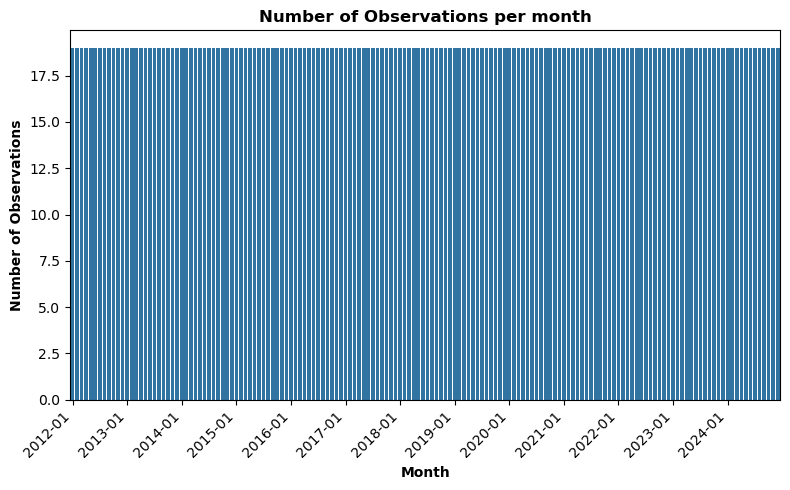

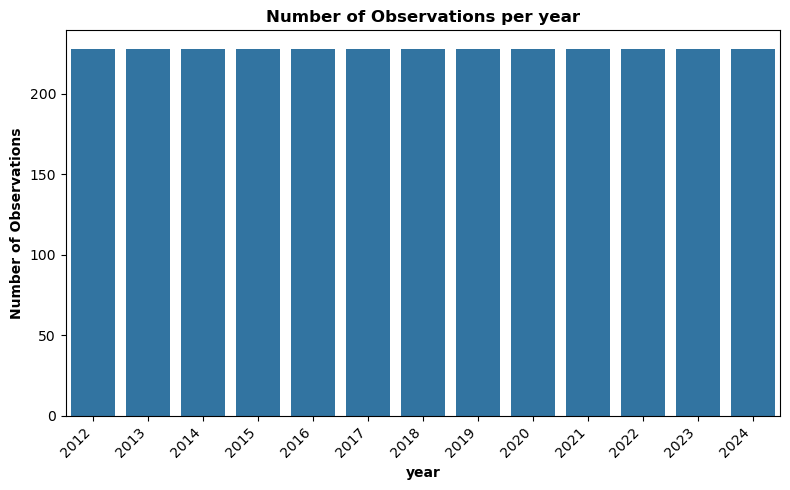

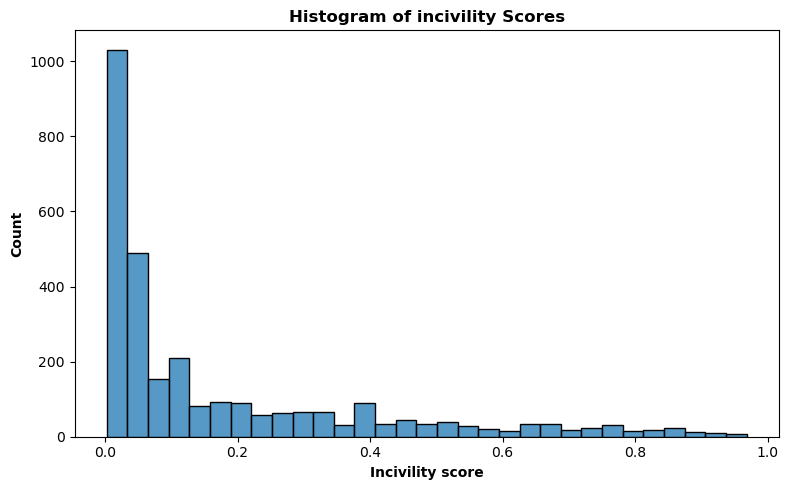

W = 0.744, p = 1.31e-55


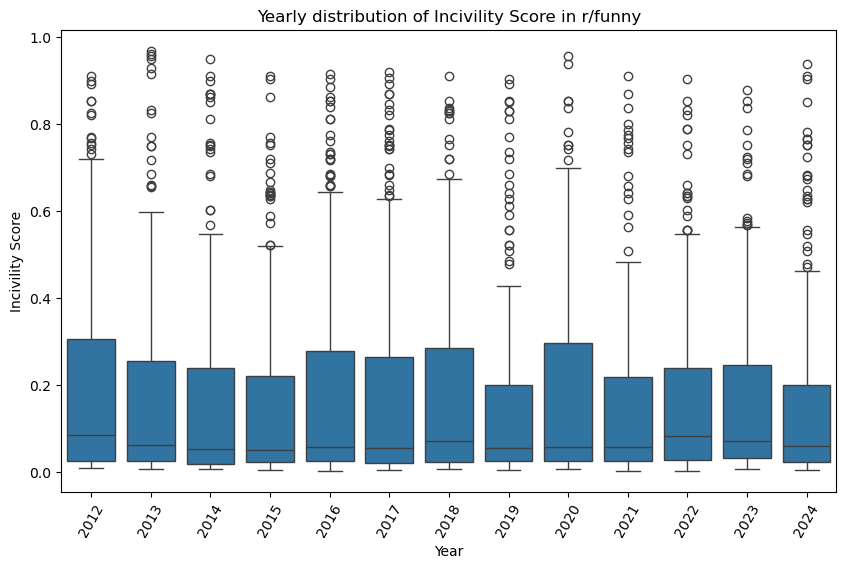

Mean 2012: 0.20561250423464913. Mean 2024: 0.16307526994517543. Relative Increase: 0.7931194192308005


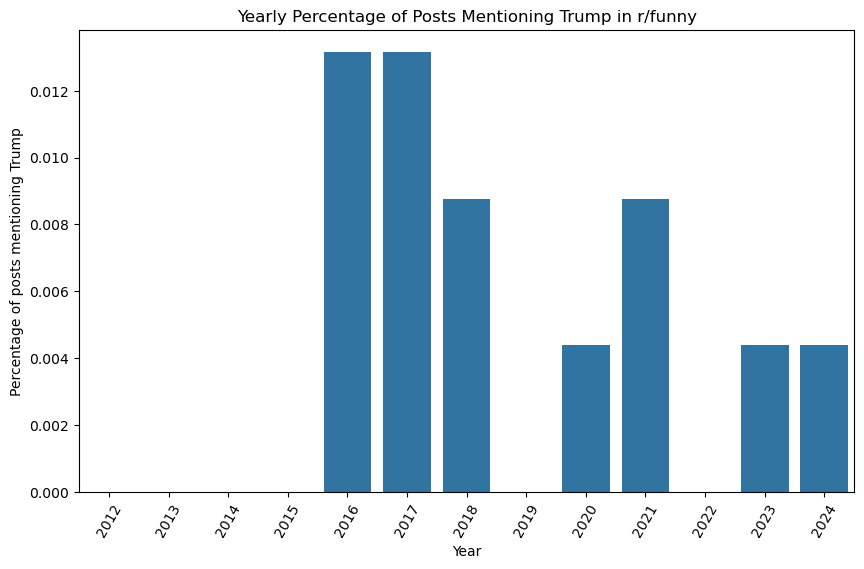

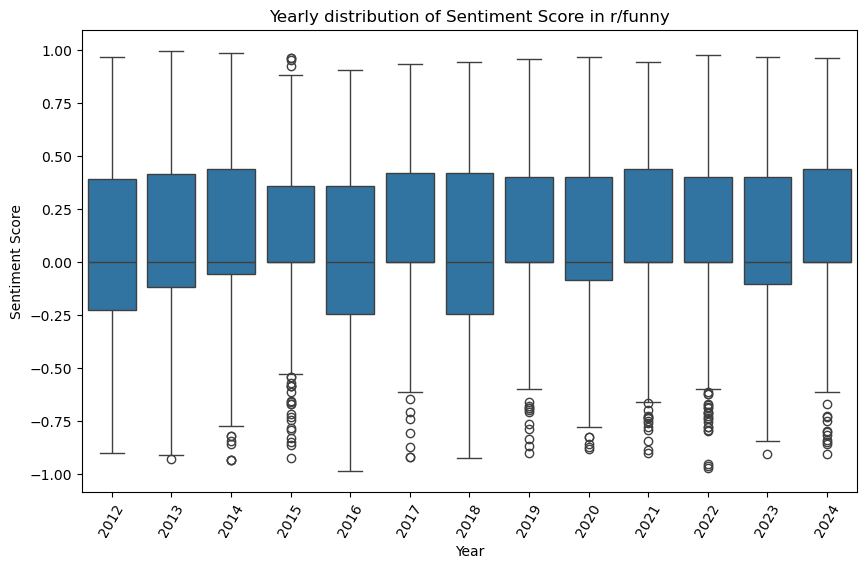

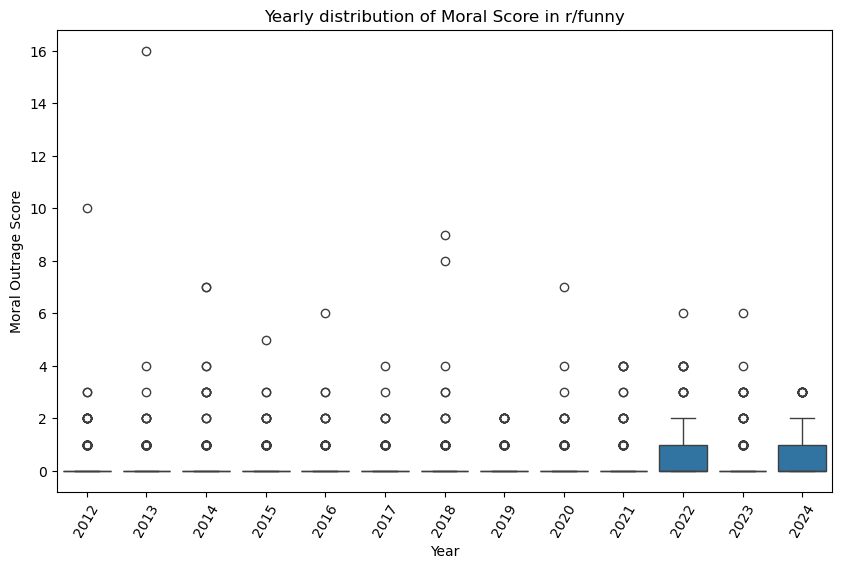

Top 2 Incivility Tweets:

Score: 0.968226
Tweet: You're bitching about it right now, you fucking idiot. 

Score: 0.96069145
Tweet: Fuck you and your goddam spam!

Bottom 2 Incivility Tweets:

Score: 0.0024346744
Tweet: Laurel.

Score: 0.0034870822
Tweet: New car sales in the US are now 4% electric, up from 2% a year ago: 

https://reddit.com/r/electricvehicles/comments/tdw704/us_january_sales_bev_share_43_of_total_market_up/

New car sales in Europe are now about 10% electric.



In [13]:

run_all_descriptives(funny_with_scores, "funny")

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.318
Date:                Sun, 21 Sep 2025   Prob (F-statistic):             0.0704
Time:                        19:20:56   Log-Likelihood:                 234.69
No. Observations:                 156   AIC:                            -465.4
Df Residuals:                     154   BIC:                            -459.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1896      0.009     21.991      0.0

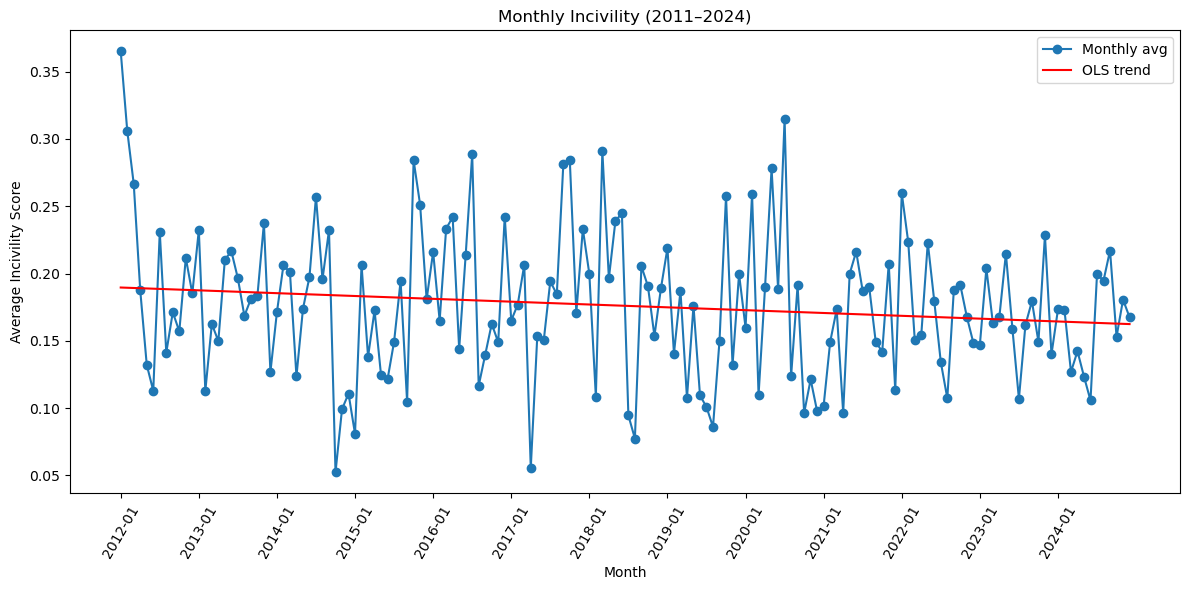

              0        1
const   0.17257  0.20663
month_ -0.00037  0.00001
                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.570
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.213
Time:                        19:20:57   Log-Likelihood:                 137.05
No. Observations:                  96   AIC:                            -270.1
Df Residuals:                      94   BIC:                            -265.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

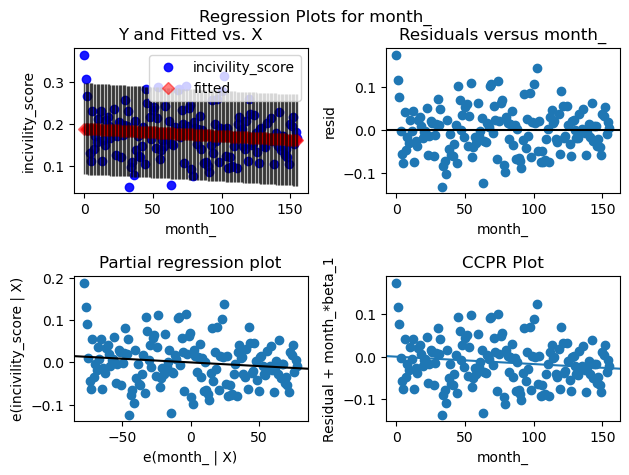

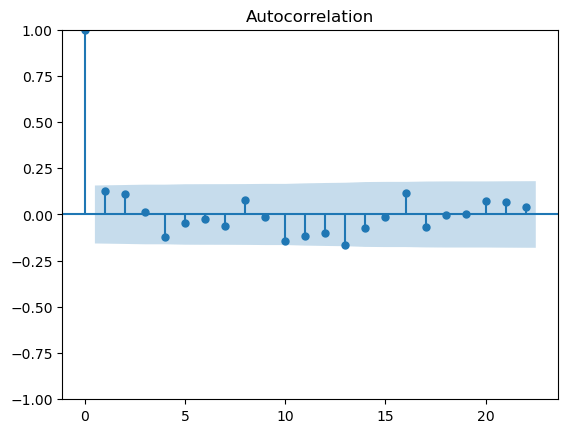

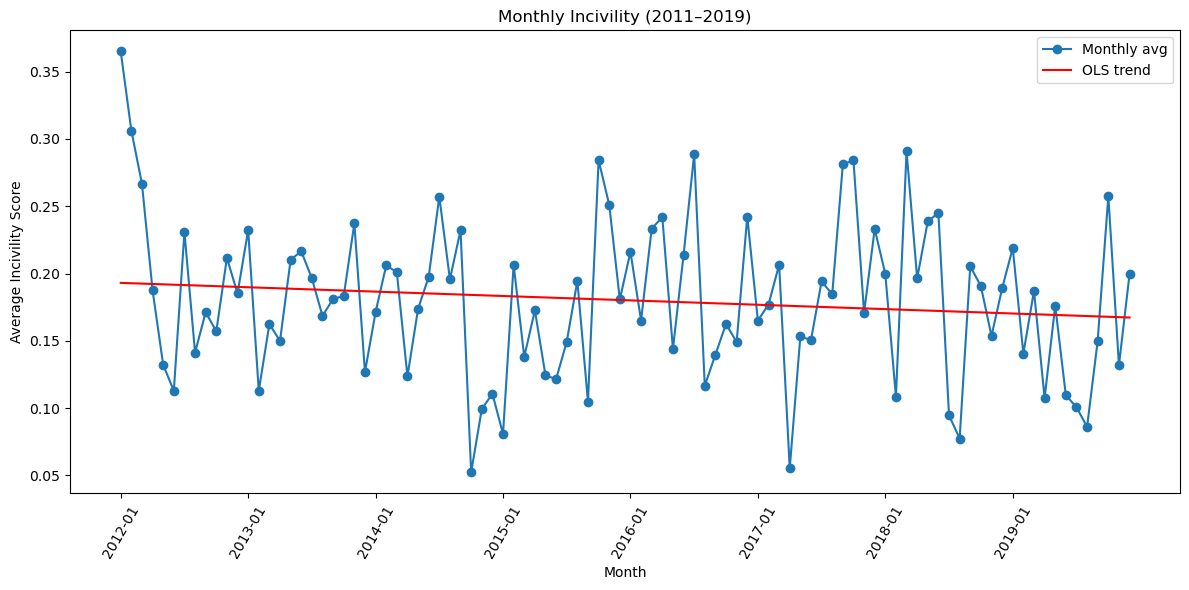

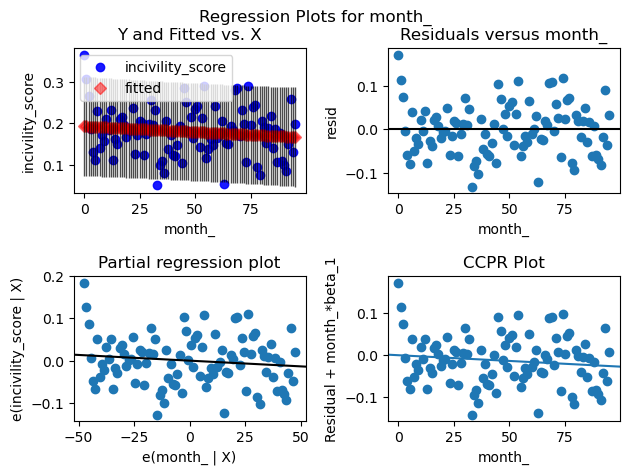

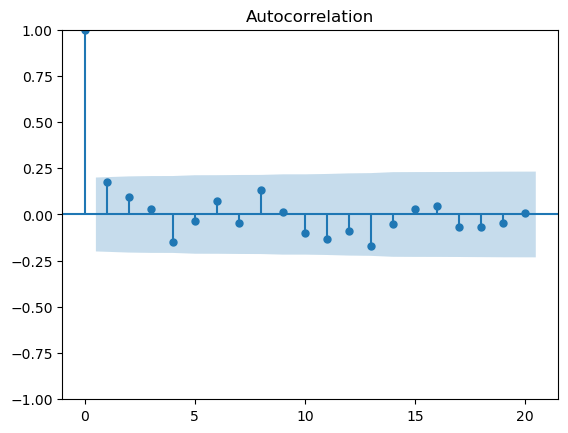

In [14]:
linreg_predicting_incivility(funny_with_scores)
linreg_predicting_incivility_2012_to_2019(funny_with_scores)

2.4 Run descriptives and inferential statistics on r/politics

In [15]:
politics_with_scores = pd.read_csv("politics_with_scores.csv")
politics_with_scores = preprocess(politics_with_scores)



Mentioning Trump Computation done


C:\Users\TG2023\AppData\Local\Temp\ipykernel_22320\390790507.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0772' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, 'sentiment_score'] = sentiment_dict['compound']


Sentiment Score Computation done
Moral Outrage Computation done
Incivility Standardisation done


        created_utc        score  incivility_score  mentions_trump  \
count  2.964000e+03  2964.000000       2964.000000     2964.000000   
mean   1.530492e+09    10.623482          0.193354        0.082659   
std    1.184520e+08   104.593487          0.227180        0.275412   
min    1.325541e+09   -77.000000          0.000000        0.000000   
25%    1.427965e+09     1.000000          0.026617        0.000000   
50%    1.530424e+09     2.000000          0.092647        0.000000   
75%    1.632401e+09     4.000000          0.292685        0.000000   
max    1.735486e+09  4131.000000          0.964267        1.000000   

       mentions_trump_z  sentiment_score  sentiment_score_z  moral_outrage  \
count      2.964000e+03      2964.000000       2.964000e+03    2964.000000   
mean       3.835588e-17         0.005126       3.116416e-17       0.660594   
std        1.000169e+00         0.519791       1.000169e+00       1.364236   
min       -3.001777e-01        -0.995100      -1.924608e+

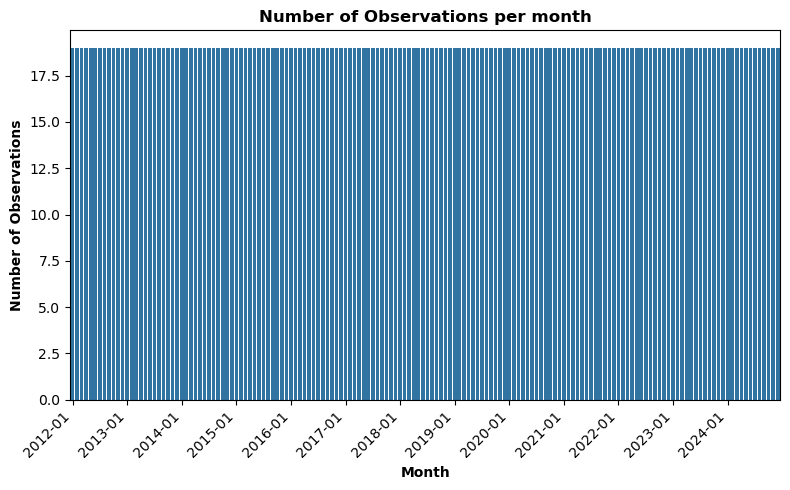

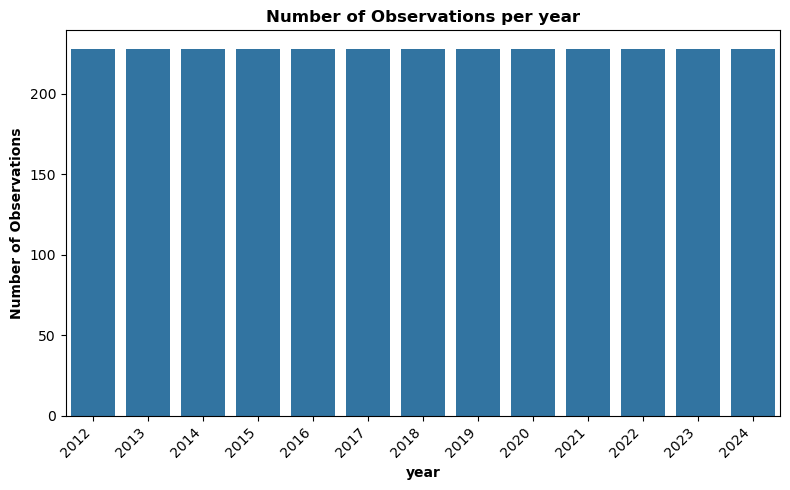

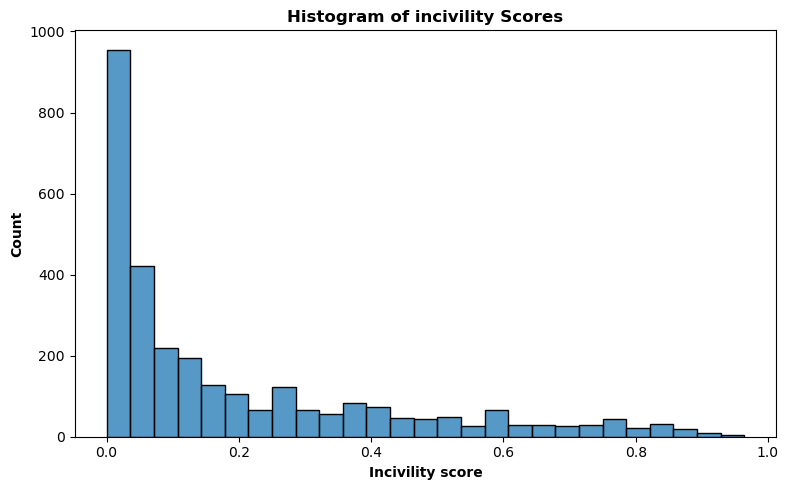

W = 0.783, p = 1.02e-52


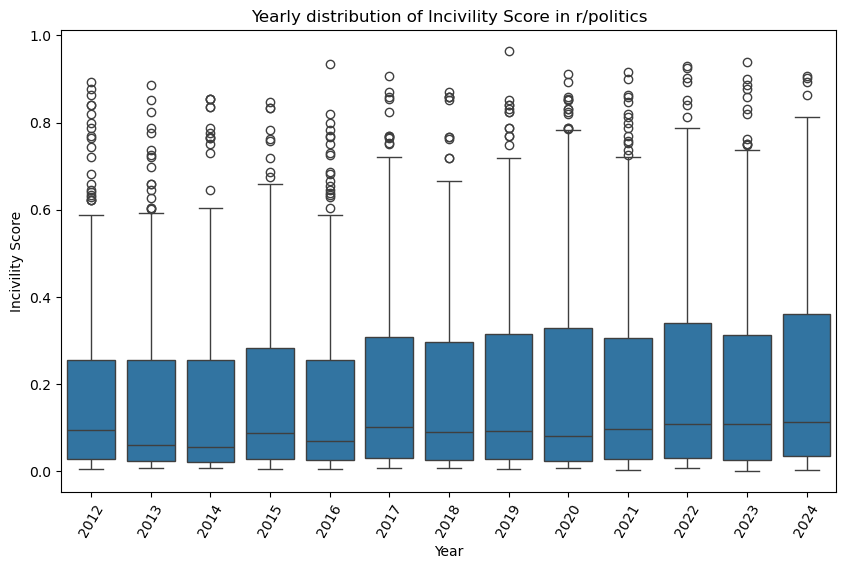

Mean 2012: 0.1832192686017544. Mean 2024: 0.2171028359039474. Relative Increase: 1.1849345189552218


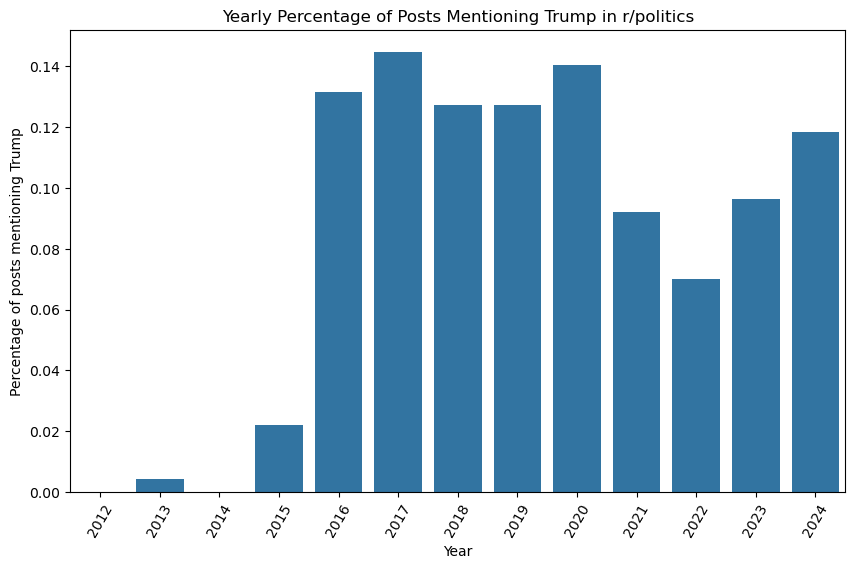

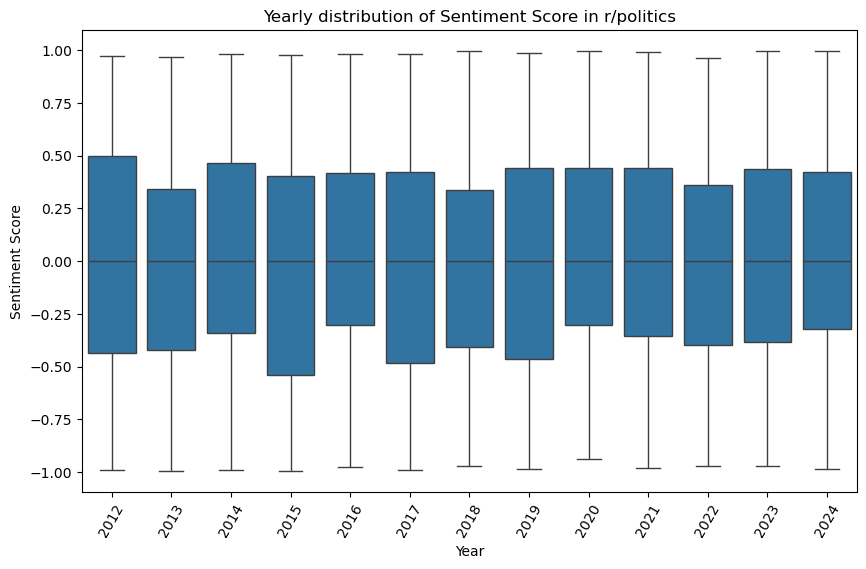

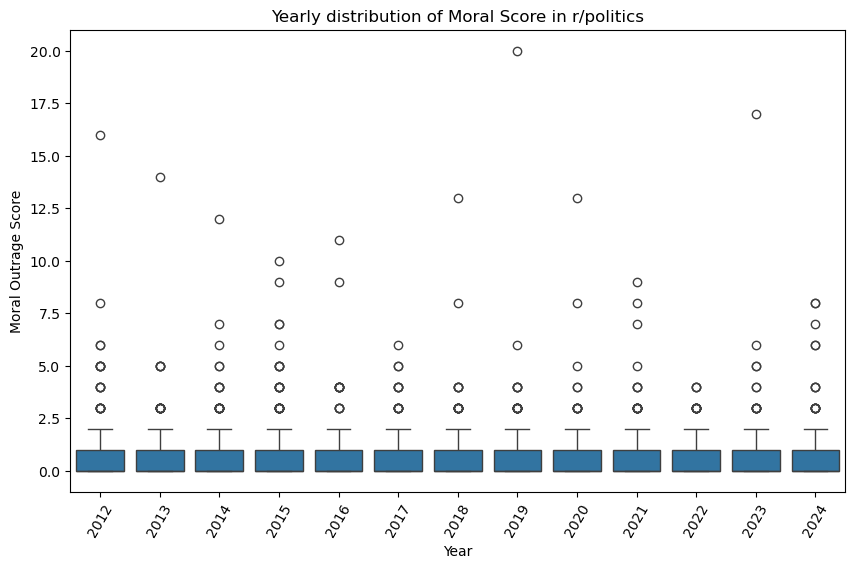

Top 2 Incivility Tweets:

Score: 0.96426713
Tweet: is he that fucking stupid, or just a fucking lackey?

Score: 0.9391453
Tweet: Stop taking about the lady bugs, fucking gross

Bottom 2 Incivility Tweets:

Score: 0.0
Tweet: Vowing to obey your partner should stay in the bedroom with the rest of the subdom kink.

Score: 0.0016414418
Tweet: Guantanamo resort.



In [16]:

run_all_descriptives(politics_with_scores, "politics")

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     13.89
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           0.000271
Time:                        19:23:40   Log-Likelihood:                 257.15
No. Observations:                 156   AIC:                            -510.3
Df Residuals:                     154   BIC:                            -504.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1693      0.007     22.677      0.0

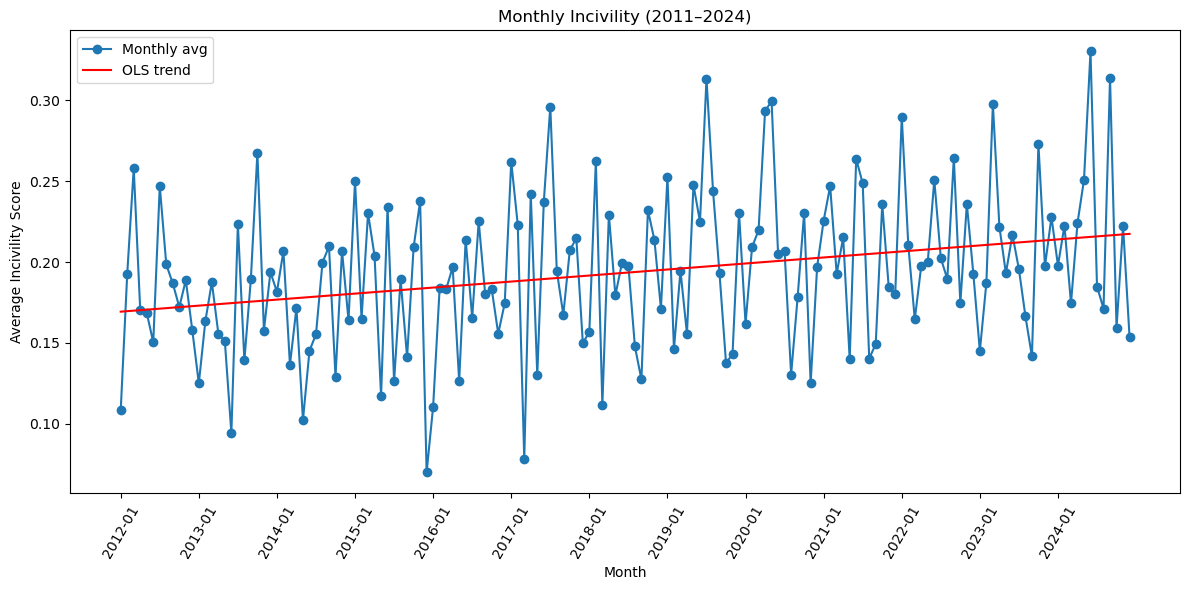

              0        1
const   0.15455  0.18404
month_  0.00015  0.00047
                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.551
Date:                Sun, 21 Sep 2025   Prob (F-statistic):             0.0626
Time:                        19:23:40   Log-Likelihood:                 158.63
No. Observations:                  96   AIC:                            -313.3
Df Residuals:                      94   BIC:                            -308.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

<Figure size 640x480 with 0 Axes>

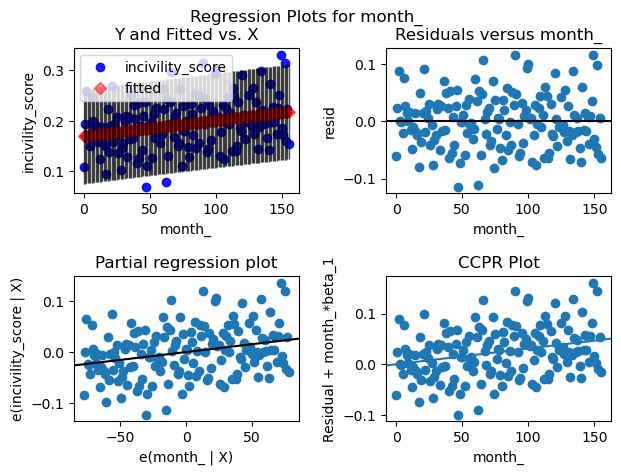

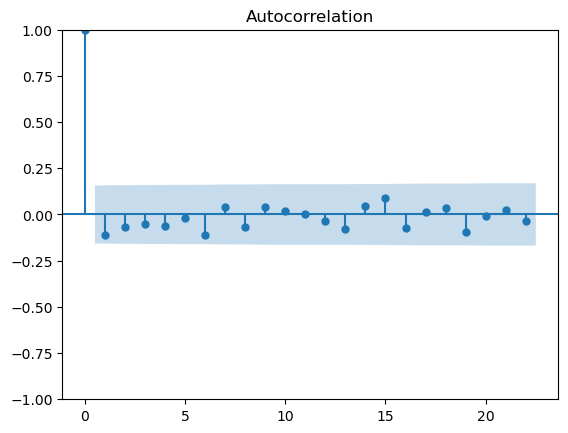

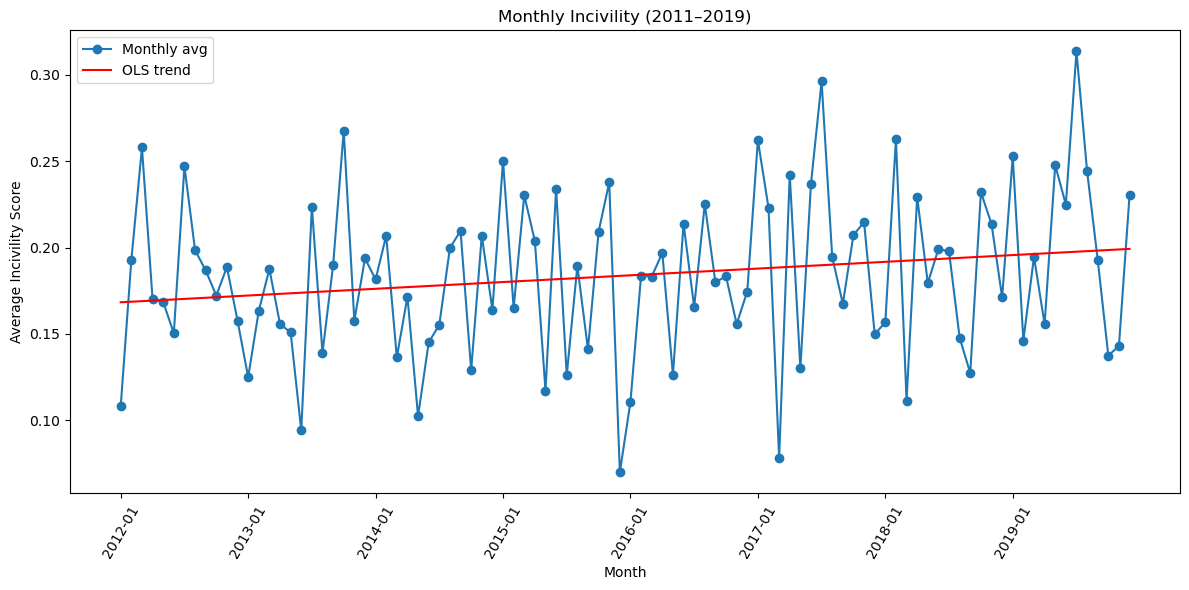

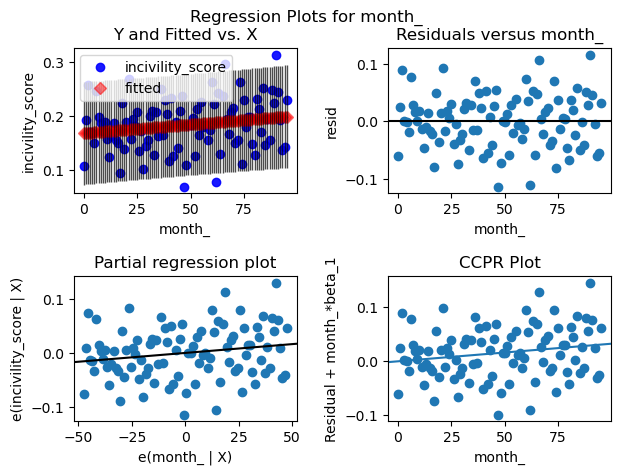

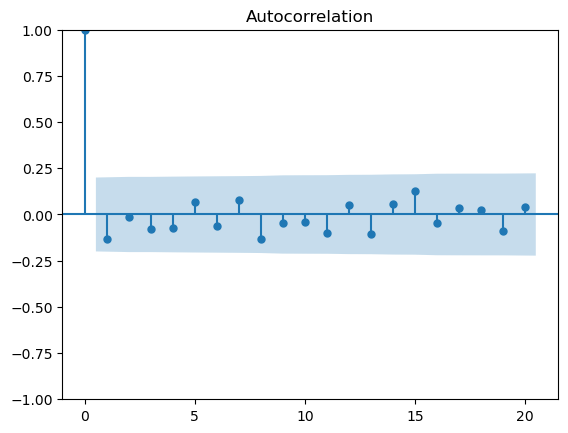

In [22]:
linreg_predicting_incivility(politics_with_scores)

linreg_predicting_incivility_2012_to_2019(politics_with_scores)


2.5 Run descriptives and inferential statistics on all 4 combined subreddits 

In [18]:
list_of_dfs = [politics_with_scores , Conservative_with_scores, Liberal_with_scores, funny_with_scores]

all_subreddits_with_scores = pd.concat(list_of_dfs)

In [19]:
all_subreddits_with_scores["year"] = (
    all_subreddits_with_scores["year"]
    .apply(lambda x: x.year if hasattr(x, "year") else x)
    .astype(int)
)

        created_utc         score  incivility_score          year  \
count  1.185600e+04  11856.000000      11856.000000  11856.000000   
mean   1.530472e+09      9.714069          0.189113   2018.000000   
std    1.184358e+08    120.453495          0.222056      3.741815   
min    1.325450e+09    -86.000000          0.000000   2012.000000   
25%    1.427895e+09      1.000000          0.027207   2015.000000   
50%    1.530408e+09      2.000000          0.087956   2018.000000   
75%    1.632978e+09      5.000000          0.285497   2021.000000   
max    1.735552e+09   8751.000000          0.974994   2024.000000   

       mentions_trump  mentions_trump_z  sentiment_score  sentiment_score_z  \
count    11856.000000      1.185600e+04     11856.000000       1.185600e+04   
mean         0.062416      3.835588e-17         0.018970       2.517105e-17   
std          0.241919      1.000042e+00         0.506587       1.000042e+00   
min          0.000000     -3.274287e-01        -0.997000      

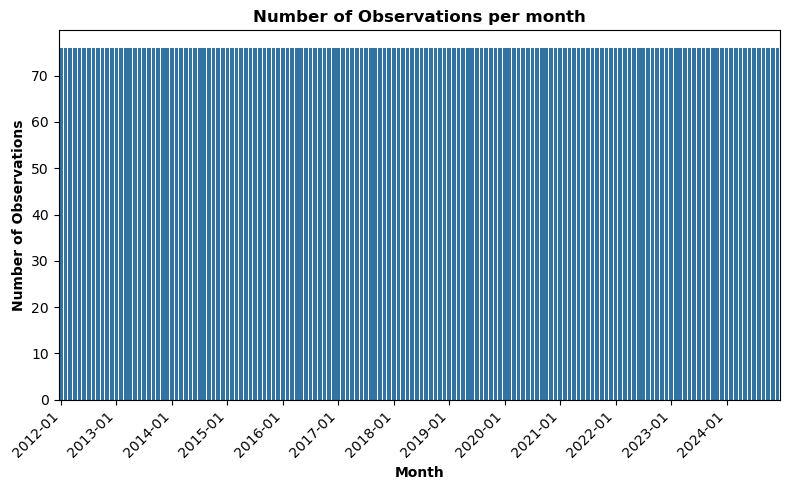

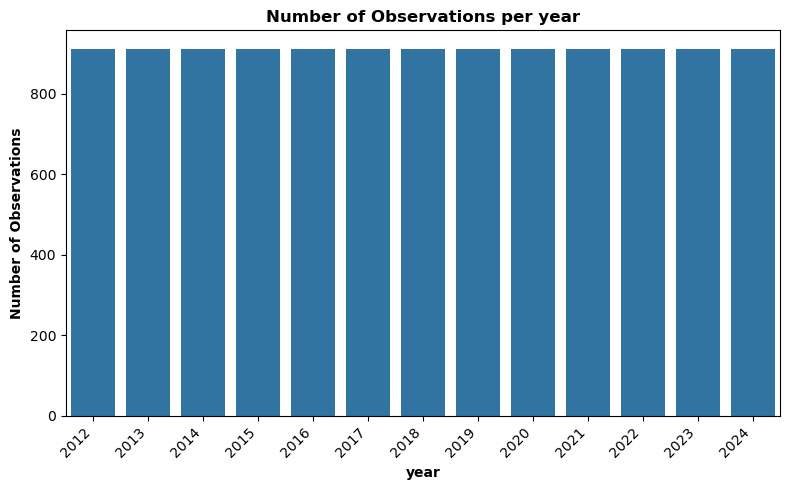

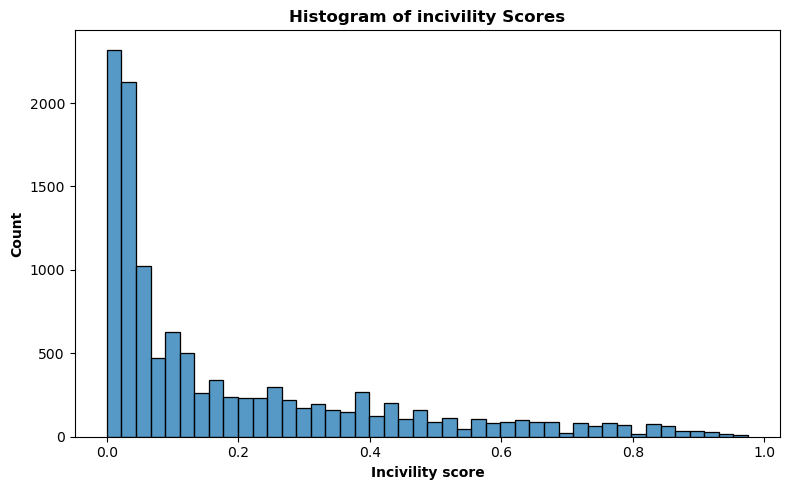

c:\Users\TG2023\anaconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11856.
  res = hypotest_fun_out(*samples, **kwds)


W = 0.782, p = 2.49e-82


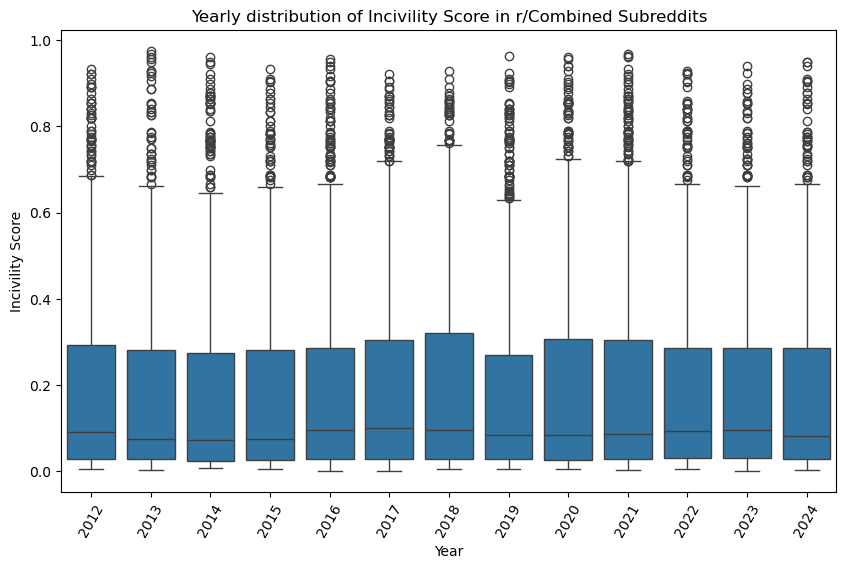

AttributeError: Can only use .dt accessor with datetimelike values

In [20]:
run_all_descriptives(all_subreddits_with_scores, "Combined Subreddits")    

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.04384
Date:                Sat, 20 Sep 2025   Prob (F-statistic):              0.834
Time:                        14:46:41   Log-Likelihood:                 344.89
No. Observations:                 156   AIC:                            -685.8
Df Residuals:                     154   BIC:                            -679.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1899      0.004     44.637      0.0

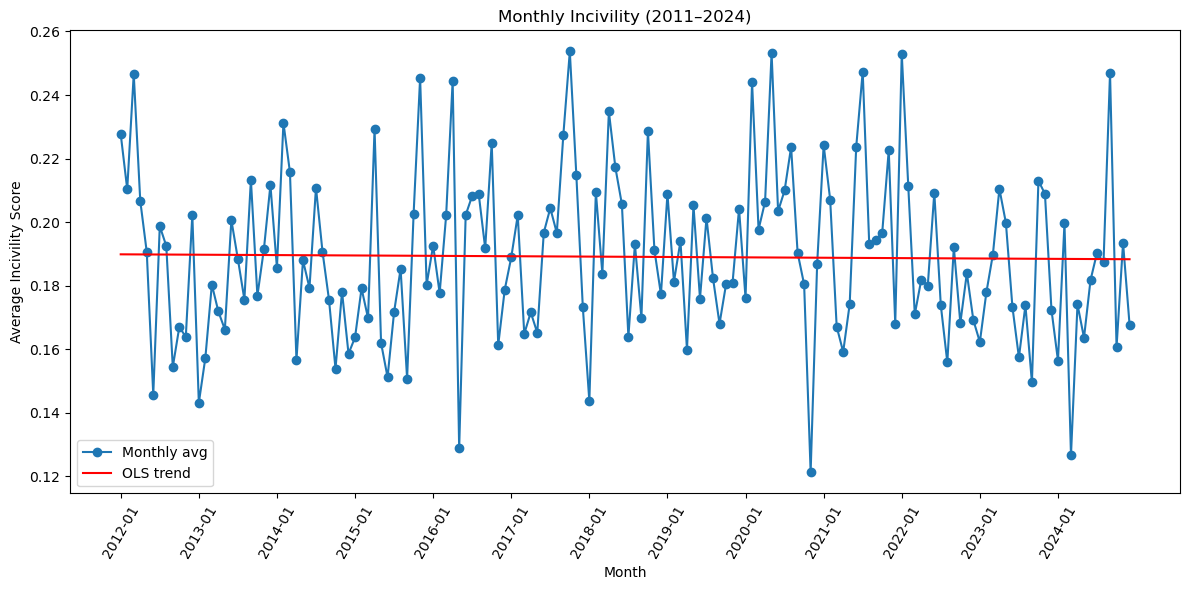

                            OLS Regression Results                            
Dep. Variable:       incivility_score   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.4857
Date:                Sat, 20 Sep 2025   Prob (F-statistic):              0.488
Time:                        14:46:42   Log-Likelihood:                 216.46
No. Observations:                  96   AIC:                            -428.9
Df Residuals:                      94   BIC:                            -423.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1859      0.005     35.774      0.0

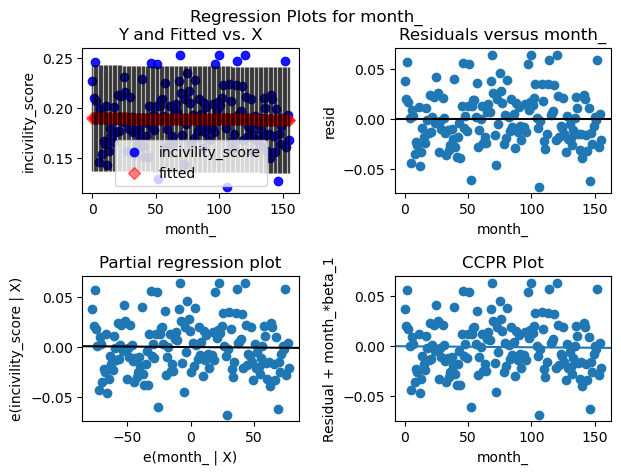

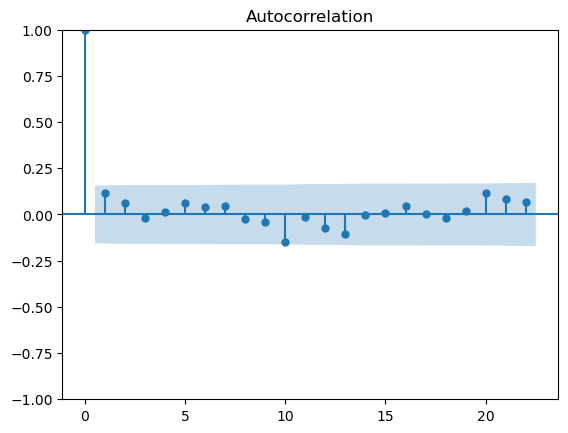

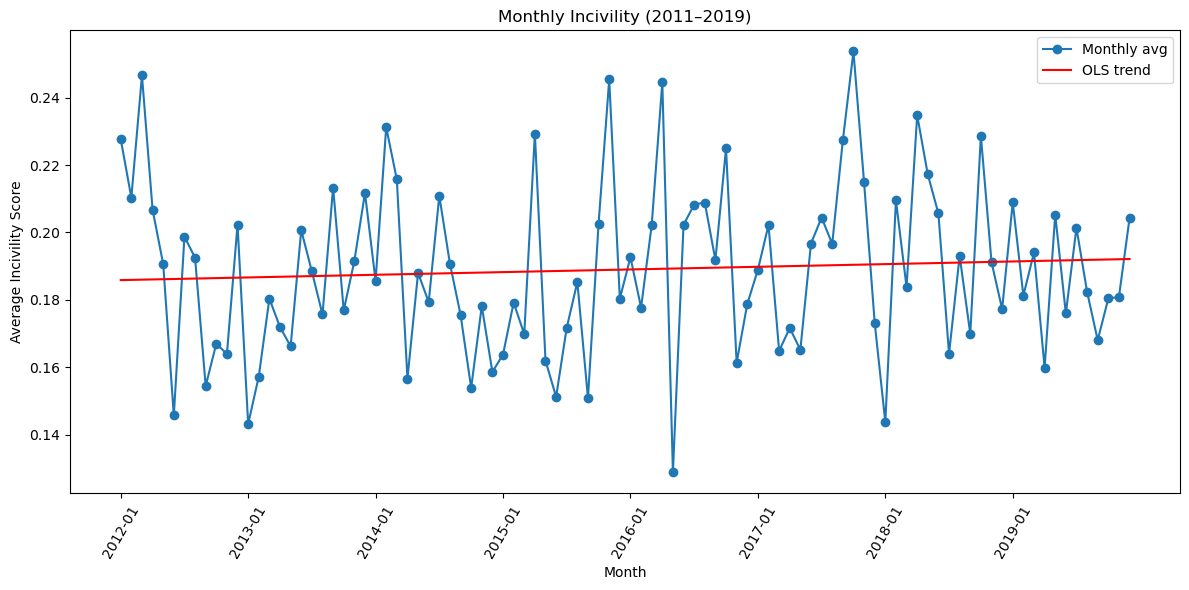

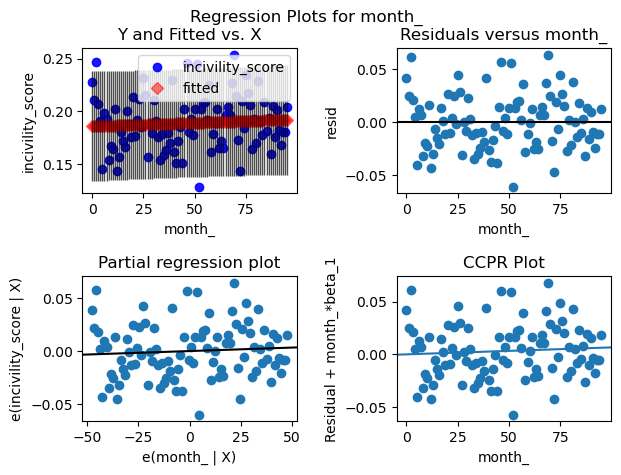

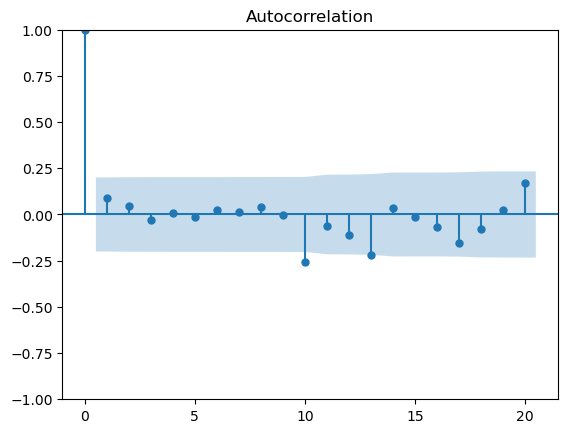

In [ ]:
linreg_predicting_incivility(all_subreddits_with_scores)
linreg_predicting_incivility_2012_to_2019(all_subreddits_with_scores)

3.0 controlling model for up-/downvotes, mentioning trump, moral outrage and sentiment score on r/politics



In [ ]:


def conditioned_incivility_metrics(data):
    # aggregating monthly averages
    scaler = StandardScaler()
    data['score_z'] = scaler.fit_transform(data[['score']])
    monthly = data.groupby('month')[['incivility_score', 'moral_outrage_z', 'mentions_trump_z', 'sentiment_score_z','score_z']].mean().reset_index()

    monthly = monthly[monthly['month'].dt.year >= 2012].reset_index(drop=True)
    monthly['month_'] = range(len(monthly))
    
    # Standardize month predictor and incivility
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    monthly['month_z'] = scaler_X.fit_transform(monthly[['month_']])
    monthly['incivility_score_z'] = scaler_y.fit_transform(monthly[['incivility_score']])
    
    mediators = ['moral_outrage_z', 'mentions_trump_z', 'sentiment_score_z', 'score_z']
    
    effects = []
    
    # Total effect (no mediator)
    formula_total = "incivility_score_z ~ month_z"
    model_total = ols(formula_total, data=monthly).fit()
    coef = model_total.params['month_z']
    ci = model_total.conf_int().loc['month_z']
    effects.append({'mediator':'Total', 'coef':coef, 'ci_lower':ci[0], 'ci_upper':ci[1], 'pval': model_total.pvalues['month_z']})
    
    # Conditioned effects
    for med in mediators:
        formula = f"incivility_score_z ~ month_z + {med}"
        model = ols(formula, data=monthly).fit()
        coef = model.params['month_z']
        ci = model.conf_int().loc['month_z']
        effects.append({'mediator':med, 'coef':coef, 'ci_lower':ci[0], 'ci_upper':ci[1], 'pval': model.pvalues['month_z']})
    
    effects_df = pd.DataFrame(effects)
    print(effects_df)
    
    # plotting
    plt.figure(figsize=(8,6))
    colors = ['black', 'C0', 'C1', 'C2', 'C4']
    for i, row in effects_df.iterrows():
        plt.errorbar(x=i, y=row['coef'], 
                     yerr=[[row['coef']-row['ci_lower']], [row['ci_upper']-row['coef']]],
                     fmt='o', color=colors[i], capsize=5)
    plt.xticks(range(len(effects_df)), effects_df['mediator'])
    plt.ylabel("Effect of Time on Incivility (z-score)")
    plt.title("Conditioned Rise of Incivility Over Time")
    plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return effects_df


            mediator      coef  ci_lower  ci_upper      pval
0              Total  0.287667  0.135206  0.440127  0.000271
1    moral_outrage_z  0.311169  0.156806  0.465532  0.000105
2   mentions_trump_z  0.222773  0.054431  0.391115  0.009833
3  sentiment_score_z  0.290867  0.141325  0.440409  0.000178
4            score_z  0.285765  0.130656  0.440873  0.000373


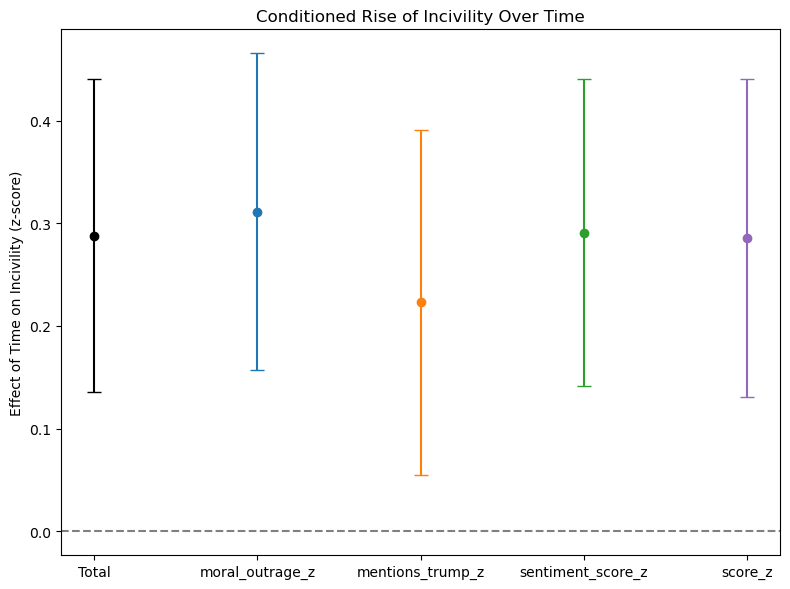

mediator      coef  ci_lower  ci_upper      pval
0              Total  0.287667  0.135206  0.440127  0.000271
1    moral_outrage_z  0.311169  0.156806  0.465532  0.000105
2   mentions_trump_z  0.222773  0.054431  0.391115  0.009833
3  sentiment_score_z  0.290867  0.141325  0.440409  0.000178
4            score_z  0.285765  0.130656  0.440873  0.000373

In [ ]:
conditioned_incivility_metrics(politics_with_scores)

4.0 Checking Hypothesis 2: There is a correlation between Upvotes and Incivil language r/politics

Spearman rho = -0.003, p = 0.875


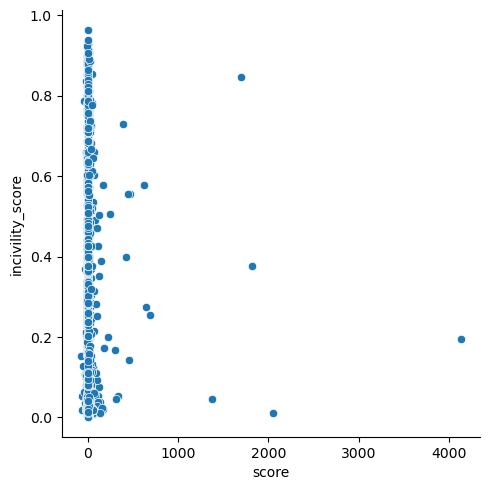

In [ ]:
# correlation (is skewed so spearman)


data = politics_with_scores
# Spearman correlation (rank-based, robust to outliers)
spearman_corr, spearman_p = spearmanr(data['score'], data['incivility_score'])
print(f"Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3f}")

# plotting 
sns.relplot(data=data, x="score", y="incivility_score")


            mediator      coef  ci_lower  ci_upper      pval
0              Total -0.124746 -0.282692  0.033200  0.120754
1    moral_outrage_z -0.146029 -0.321968  0.029909  0.103113
2   mentions_trump_z -0.157411 -0.338038  0.023217  0.087152
3  sentiment_score_z -0.083159 -0.235653  0.069334  0.283019
4            score_z -0.020497 -0.204783  0.163788  0.826368


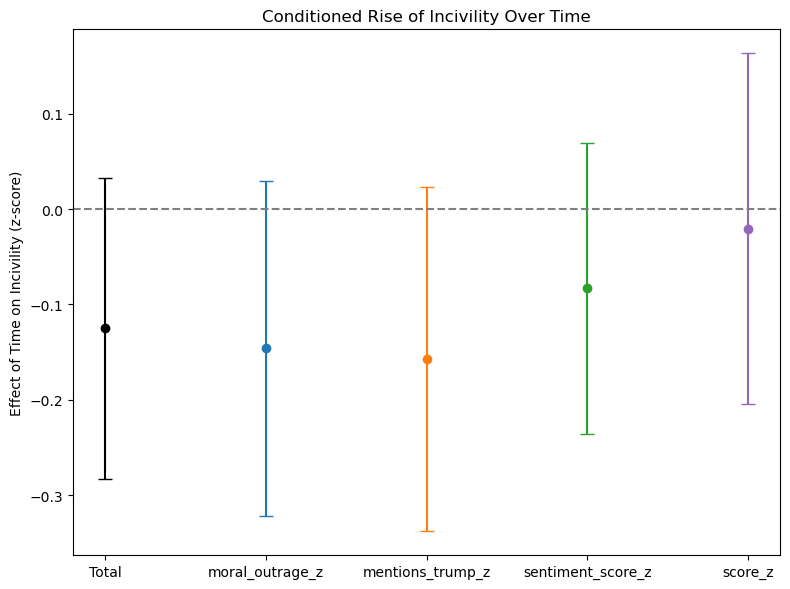

Spearman rho = 0.022, p = 0.237


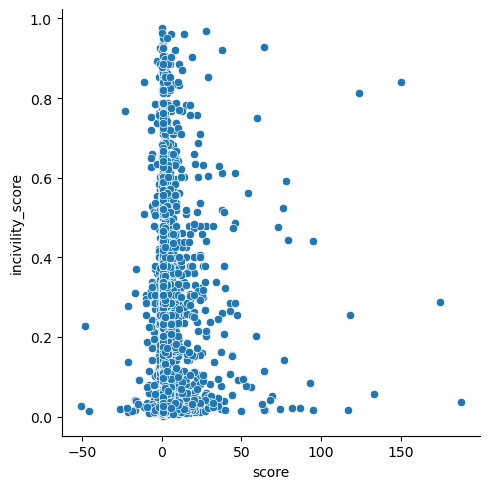

In [ ]:
# checking for liberal
data = Liberal_with_scores
conditioned_incivility_metrics(data)
spearman_corr, spearman_p = spearmanr(data['score'], data['incivility_score'])
print(f"Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3f}")
sns.relplot(data=data, x="score", y="incivility_score")

            mediator      coef  ci_lower  ci_upper      pval
0              Total -0.026097 -0.185232  0.133039  0.746408
1    moral_outrage_z -0.007007 -0.173306  0.159292  0.933769
2   mentions_trump_z -0.025791 -0.192379  0.140797  0.760130
3  sentiment_score_z -0.003667 -0.154801  0.147468  0.961836
4            score_z -0.026573 -0.210773  0.157626  0.776024


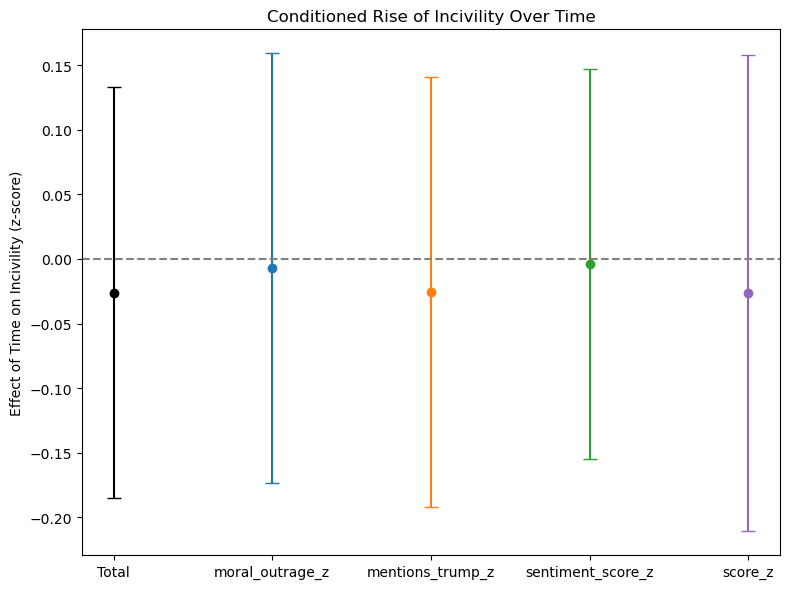

Spearman rho = 0.045, p = 0.014


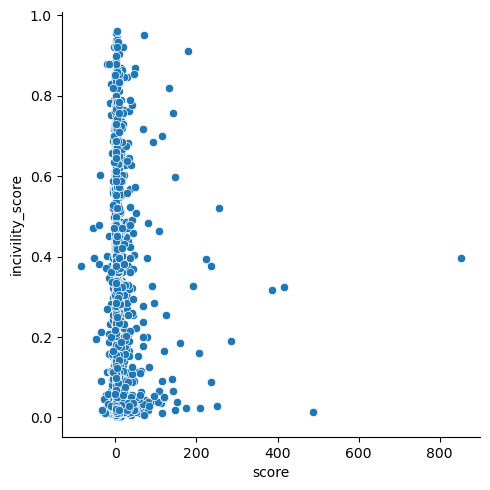

In [ ]:
# checking for conservative
data = Conservative_with_scores
conditioned_incivility_metrics(data)
spearman_corr, spearman_p = spearmanr(data['score'], data['incivility_score'])
print(f"Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3f}")
sns.relplot(data=data, x="score", y="incivility_score" )

            mediator      coef  ci_lower  ci_upper      pval
0              Total -0.145236 -0.302738  0.012265  0.070449
1    moral_outrage_z -0.157473 -0.316800  0.001853  0.052691
2   mentions_trump_z -0.147487 -0.305890  0.010917  0.067789
3  sentiment_score_z -0.111861 -0.264969  0.041247  0.150961
4            score_z -0.149501 -0.305636  0.006635  0.060429


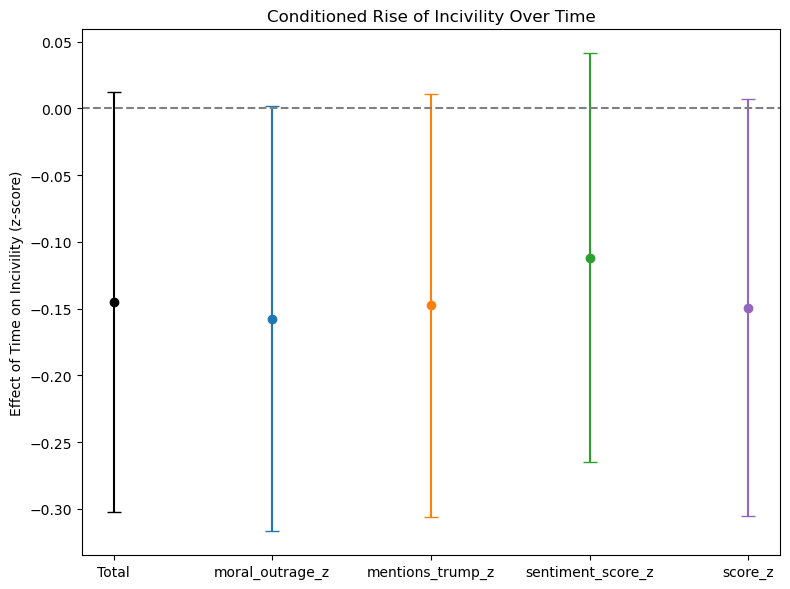

Spearman rho = -0.030, p = 0.104


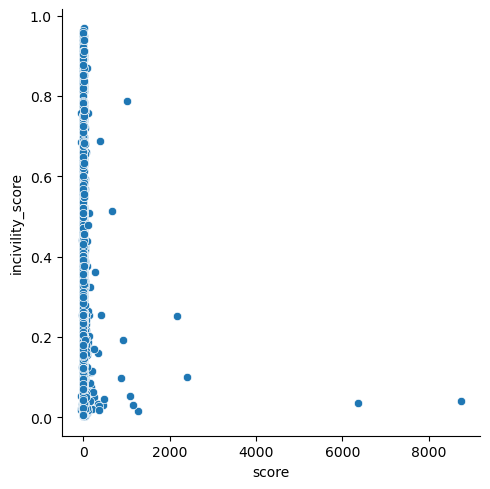

In [ ]:
# checking for funny
data = funny_with_scores
conditioned_incivility_metrics(data)
spearman_corr, spearman_p = spearmanr(data['score'], data['incivility_score'])
print(f"Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3f}")
sns.relplot(data=data, x="score", y="incivility_score")

            mediator      coef  ci_lower  ci_upper      pval
0              Total -0.016870 -0.176036  0.142297  0.834431
1    moral_outrage_z -0.033244 -0.206102  0.139613  0.704510
2   mentions_trump_z -0.070823 -0.251124  0.109478  0.438936
3  sentiment_score_z  0.043191 -0.107909  0.194292  0.573096
4            score_z -0.073464 -0.229996  0.083068  0.355290


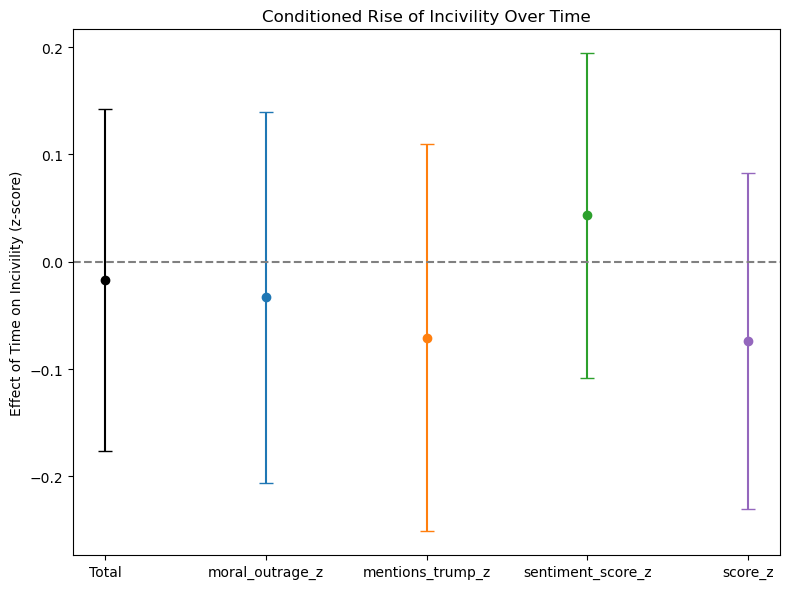

Spearman rho = 0.010, p = 0.269


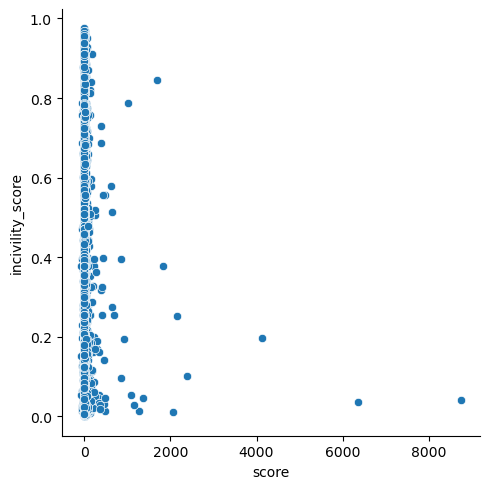

In [ ]:
# checking for all subreddits combined
data = all_subreddits_with_scores
conditioned_incivility_metrics(data)
spearman_corr, spearman_p = spearmanr(data['score'], data['incivility_score'])
print(f"Spearman rho = {spearman_corr:.3f}, p = {spearman_p:.3f}")
sns.relplot(data=data, x="score", y="incivility_score")

4. Additional Plots


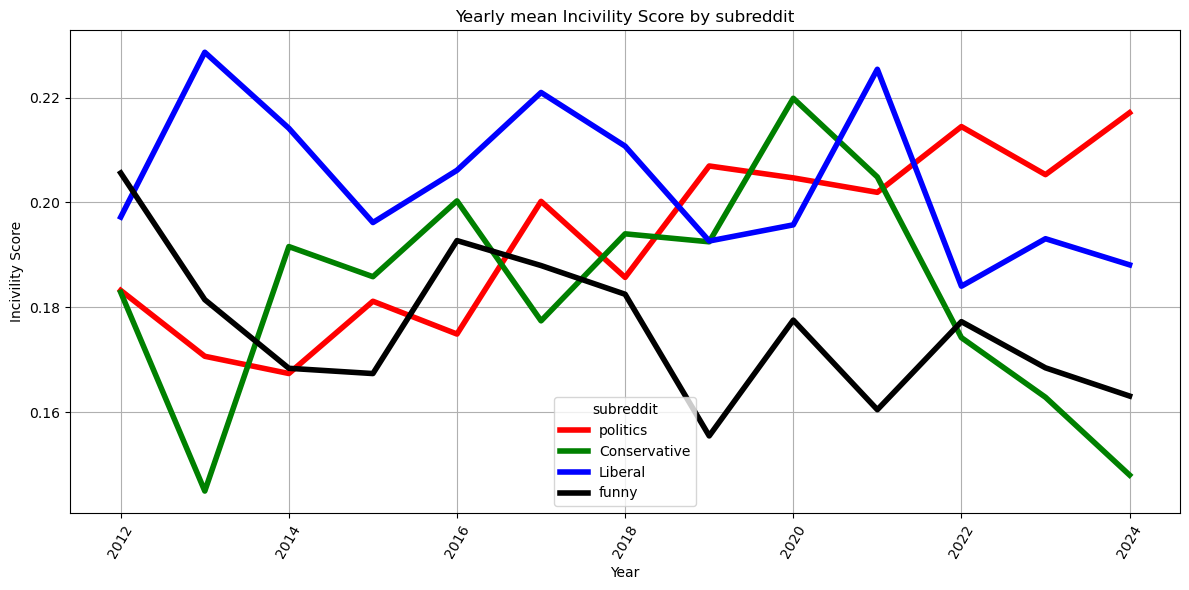

In [ ]:
# Plotting mean Incivility Scores of all 4 Subreddits by year for comparison
plt.figure(figsize=(12,6))
colors = {"politics" : "red", "Liberal": "blue", "Conservative": "green", "funny": "black" }
sns.lineplot(
    data=all_subreddits_with_scores,
    x="year",
    y="incivility_score",
    hue="subreddit",
    err_style=None,
    palette= colors,
    linewidth = 4
         
)
plt.xlabel("Year")
plt.ylabel("Incivility Score")
plt.xticks(rotation=60)
plt.title(f"Yearly mean Incivility Score by subreddit")
plt.tight_layout()
plt.grid(True)
plt.show()

